# Quantifications of area and growth

## Documentation and Imports


Created on 01-04-2021

Author: Valentin Laplaud

This code is loading data from different experiment, created by ShapeQuatification. It plots those various data and compare them to each other.

In [1]:
## Clean up before script start 

for element in dir():

    if element[0:1] != "_":

        del globals()[element]

import gc
gc.collect()


print('\033[1m' + '\033[4m' + '\nRunning :  ''ExperimentComparisonNB''\n' + '\033[0m')

import datetime

# plotting stuff
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline

COLOR = 'white'
COLOR2 = 'black'

mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR

mpl.rcParams["figure.facecolor"] = COLOR2
mpl.rcParams["axes.facecolor"] = COLOR2
mpl.rcParams["savefig.facecolor"] = COLOR2
mpl.rcParams['axes.facecolor'] = COLOR2

import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
import seaborn as sns
from cycler import cycler
#Default colors
colorcycle = [plt.get_cmap('gist_rainbow')(1. * i/30) for i in range(30)]
mpl.rcParams['axes.prop_cycle'] = cycler(color=colorcycle)

# numbers handling
import numpy as np
import numpy.matlib as mtl
import pandas as pd

# signal processing 
from scipy.signal import savgol_filter, correlate, correlation_lags
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# stats
from scipy.stats import ranksums, linregress, ks_2samp
import statsmodels.api as sm
from statsmodels.formula.api import ols

# images handling
from skimage import io
from skimage.filters import threshold_otsu, gaussian, laplace, sobel
from skimage.measure import label, regionprops, regionprops_table
from skimage.util import invert
from skimage.morphology import binary_opening, binary_closing, remove_small_holes,binary_erosion
from skimage.color import rgb2gray
from skimage.segmentation import active_contour, morphological_geodesic_active_contour,morphological_chan_vese, checkerboard_level_set, inverse_gaussian_gradient
import cv2 as cv

# to hide known warnings
import warnings

# General system functions
import os
import shutil
import sys

import time

# my functions
sys.path.append('../')
import VallapFunc as vf



Running :  ExperimentComparisonNB



## Define functions

### Growth data visualisation

In [15]:
def compareGrowth(GDs, Labels, colors,P, Title, **kwargs):

    showcurve = False
    showbox = False
    showhist = False
    nbins = 20
    AllSigs = True
    IndividualPlots = False
    stats = 'ranksum'
    
    for key, value in kwargs.items(): 
        if key == 'showcurve':
            showcurve = value 
        elif key == 'showbox':
            showbox = value
        elif key == 'showhist':
            showhist = value
        elif key == 'nbins':
            nbins = value
        elif key == 'sigpairs':
            sigpairs = value
            AllSigs = False
        elif key == 'indiplots' :
            IndividualPlots = value
        elif key == 'stats' :
            stats = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    # Colors
    colorcycle = [plt.get_cmap('gist_rainbow')(1. * i/len(GDs)) for i in range(len(GDs))]
    mpl.rcParams['axes.prop_cycle'] = cycler(color=colorcycle)
         
    # check existence of figure folder, if absent, create it
    if not os.path.exists(P + '\\Figures\\AreaGrowth'):
            os.mkdir(P + '\\Figures\\AreaGrowth') # create folder
    
    ######### Curves of evolution ##########
    
    fig2,ax2 = plt.subplots(dpi = 250,facecolor='black')
    fig2.suptitle(Title + ' - Area vs. time')
    plt.xlabel('Time (min)')
    plt.ylabel('Area (mm²)')
    
    fig3,ax3 = plt.subplots(dpi = 250,facecolor='black')
    fig3.suptitle(Title + ' - Norm Area vs. time')
    plt.xlabel('Time (min)')
    plt.ylabel('Area (normalized)')
    
    """  fig10,ax10 = plt.subplots(dpi = 250,facecolor='black')
    fig10.suptitle(Title + ' - Area vs. aligned time')
    plt.xlabel('Time (min)')
    plt.ylabel('Area (mm²)')
    
    fig11,ax11 = plt.subplots(dpi = 250,facecolor='black')
    fig11.suptitle(Title + ' - Norm Area vs. aligned time')
    plt.xlabel('Time (min)')
    plt.ylabel('Area (normalized)')"""
    
    for GD,lab,i in zip(GDs,Labels,range(len(GDs))):
        
        StackList = np.unique(GD.index)
        
        if IndividualPlots:
            imgs = range(49)
            fig1,ax1 = plt.subplots(dpi = 250,facecolor='black')
            fig1.suptitle(lab + ' - Area vs. time')
            plt.xlabel('Time (min)')
            plt.ylabel('Area (mm²)')
            for s in StackList:
                ax1.plot(np.multiply(imgs,30),GD.loc[(GD.index == s) & (GD['Img'].values<49),'Area'],label=s)
            plt.legend(prop={'size': 5})

        # number of ppgs and label
        nPPG = len(GD.loc[GD['Img'] == 0])
        lab = lab + ' - n = ' + str(nPPG)
        
        # Computing mean area over all gemmae for each image
        MeanA = np.empty(49)
        MeanTime = np.empty(49)
        StdA = np.empty(49)

        for im in range(49):

            MeanA[im] = GD.loc[GD['Img'] == im,'Area'].to_numpy().mean()
            MeanTime[im] = im*30
            StdA[im] = GD.loc[GD['Img'] == im,'Area'].to_numpy().std()
        
        nppg = len(GD.loc[GD['Img'] == 0,'Area'].to_numpy())

        ax2.errorbar(MeanTime,MeanA,yerr=StdA/np.sqrt(nppg), capsize=3,label=lab,color = colors[i])
        ax3.errorbar(MeanTime,MeanA/MeanA[0],yerr=StdA/MeanA[0]/np.sqrt(nppg), capsize=3,label=lab,color = colors[i])
        
        """# Computing mean of area with alignement in time based on fit
        
        AlAreas = np.empty((49,len(StackList)))
        AlAreas[:] = np.nan
        
        maxshift = 0
        
        for ii,s in zip(range(len(StackList)),StackList):
            ImgShift = GD.loc[(GD.index == s) & (GD['Img'].values == 0), 'tdebShift'].values   
            maxshift = int(np.max([maxshift,ImgShift]))
            
            for im in range(49):
                
                if (im+ImgShift)<np.max(GD['Img']+1):

                    AlAreas[im,ii] = GD.loc[(GD.index == s) & (GD['Img'].values == im+ImgShift), 'Area'].values
        
        print(np.max(GD['Img']+1)-maxshift)
        AlMeanA = np.nanmean(AlAreas[range(np.max(GD['Img']+1)-maxshift)], axis=1)
        AlStdA = np.nanstd(AlAreas[range(np.max(GD['Img']+1)-maxshift)], axis = 1)

        
        ax10.errorbar(MeanTime[range(np.max(GD['Img']+1)-maxshift)],AlMeanA,yerr=AlStdA/np.sqrt(nppg), capsize=3,label=lab,color = colors[i])
        ax11.errorbar(MeanTime[range(np.max(GD['Img']+1)-maxshift)],AlMeanA/AlMeanA[0],yerr=AlStdA/AlMeanA[0]/np.sqrt(nppg), capsize=3,label=lab,color = colors[i])
      """
   
    plt.figure(fig2.number)
    plt.legend(prop={'size': 8})
    fig2.savefig(P + '\\Figures\\AreaGrowth\\' + Title + '_AreaCurve.png')
    if not showcurve:
        plt.close(fig2)

    plt.figure(fig3.number)
    plt.legend(prop={'size': 8})
    fig3.savefig(P + '\\Figures\\AreaGrowth\\' + Title + '_NormAreaCurve.png')
    if not showcurve:
        plt.close(fig3)

    """plt.figure(fig10.number)
    plt.legend(prop={'size': 8})
    fig10.savefig(P + '\\Figures\\AliAreaTime_' + Title + '.png')
    if not showcurve:
        plt.close(fig1)

    plt.figure(fig11.number)
    plt.legend(prop={'size': 8})
    fig11.savefig(P + '\\Figures\\AliNormAreaTime_' + Title + '.png')
    if not showcurve:
        plt.close(fig1)"""

    ######### Parameters of fit ###########
    
      
    fig4,ax4 = plt.subplots(dpi = 250,facecolor='black')
    fig4.suptitle(Title + ' - Growth start time')
    plt.ylabel('T start (hours)')
      
    fig5,ax5 = plt.subplots(dpi = 250,facecolor='black')
    fig5.suptitle(Title + ' - Growth caracteristic time')
    plt.ylabel('Tau growth (hours)')
      
    fig6,ax6 = plt.subplots(dpi = 250,facecolor='black')
    fig6.suptitle(Title + ' - Starting area')
    plt.ylabel('Starting area from fit (mm²)')
    
    if len(GDs) == 2:
        # Histogram for distribution comparison
        fig7,ax7 = plt.subplots(dpi = 250,figsize = (5,3.5),facecolor='black')
        fig7.suptitle(Title + ' - Growth caracteristic times')
        plt.xlabel('Tau growth (hours)')
        plt.ylabel('PDF')

        fig8,ax8 = plt.subplots(dpi = 250,figsize = (5,3.5),facecolor='black')
        fig8.suptitle(Title + ' - Growth start time')
        plt.xlabel('T start (min)')
        plt.ylabel('PDF')
        
        fig9,ax9 = plt.subplots(dpi = 250,figsize = (5,3.5),facecolor='black')
        fig9.suptitle(Title + ' - Growth caracteristic times')
        plt.xlabel('Tau growth (hours) - median aligned')
        plt.ylabel('PDF')

        fig10,ax10 = plt.subplots(dpi = 250,figsize = (5,3.5),facecolor='black')
        fig10.suptitle(Title + ' - Growth start time')
        plt.xlabel('T start (min) - median aligned')
        plt.ylabel('PDF')
    
    tdebs= [None]*len(GDs)
    taus= [None]*len(GDs)
    stdtdebs= [None]*len(GDs)
    stdtaus= [None]*len(GDs)
    captdeb= [None]*len(GDs)
    captau= [None]*len(GDs)
    medtdeb= [None]*len(GDs)
    medtau= [None]*len(GDs)    
    
    Area0 = [None]*len(GDs)
    stdArea0 = [None]*len(GDs)
    capArea0 = [None]*len(GDs)
    medArea0 = [None]*len(GDs)
    
    grouping = []
    
    for GD,lab,i in zip(GDs,Labels,range(len(GDs))):
        
        # number of ppgs and label
        nPPG = len(GD.loc[GD['Img'] == 0])
        lab = lab + '\nn = ' + str(nPPG)
        
        # Retrieve data
        tdebs[i] = GD.loc[GD['Img'] == 0, 'tdeb']/60
        taus[i] = GD.loc[GD['Img'] == 0, 'Tau']/60
        stdtdebs[i] = GD.loc[GD['Img'] == 0, 'STDtdeb']
        stdtaus[i] = GD.loc[GD['Img'] == 0, 'STDTau']/60        
        Area0[i] = GD.loc[GD['Img'] == 0, 'A0fit']
        
        # swarmplots
        grouping = np.append(grouping,np.ones(len(tdebs[i]))*i)


        plotprops = {'color':'white'}
        boxprops = {'color':'white','facecolor':colors[i]}
        flierprops = dict(marker='d', markerfacecolor=colors[i], markersize=8,
                  markeredgecolor='none')
         
        bp4 = ax4.boxplot(tdebs[i], positions = [i], labels = [lab],patch_artist = True, boxprops=boxprops, capprops =plotprops,
                    showfliers = False,whiskerprops=plotprops,medianprops =plotprops)
        
        bp5 = ax5.boxplot(taus[i], positions = [i], labels = [lab],patch_artist = True, boxprops=boxprops, capprops =plotprops,
                    showfliers = False,whiskerprops=plotprops,medianprops =plotprops)
        
        bp6 = ax6.boxplot(Area0[i], positions = [i], labels = [lab],patch_artist = True, boxprops=boxprops, capprops =plotprops,
                    showfliers = False,whiskerprops=plotprops,medianprops =plotprops)
    
        captdeb[i] = bp4['caps'][1].get_ydata(orig=True)[0]
        captau[i] = bp5['caps'][1].get_ydata(orig=True)[0]
        capArea0[i] = bp6['caps'][1].get_ydata(orig=True)[0]
        medtdeb[i] = bp4['medians'][0].get_ydata(orig=True)[0]
        medtau[i] = bp5['medians'][0].get_ydata(orig=True)[0]
        medArea0[i] = bp6['medians'][0].get_ydata(orig=True)[0]
        
        if len(GDs) == 2:
        
            ax7.hist(taus[i], nbins, density=True, facecolor=colors[i], alpha=0.5)
            ax8.hist(tdebs[i], nbins, density=True, facecolor=colors[i], alpha=0.5)
            ax9.hist(taus[i]-np.median(taus[i]), nbins, density=True, facecolor=colors[i], alpha=0.5)
            ax10.hist(tdebs[i]-np.median(tdebs[i]), nbins, density=True, facecolor=colors[i], alpha=0.5)

            
    sns.swarmplot(x=grouping,y=pd.concat(tdebs),color = 'white', size=2, ax = ax4)
    sns.swarmplot(x=grouping,y=pd.concat(taus),color = 'white', size=2, ax = ax5)
    sns.swarmplot(x=grouping,y=pd.concat(Area0),color = 'white', size=2, ax = ax6)
    
    ax4.set_xticklabels(Labels)
    ax5.set_xticklabels(Labels)
    ax6.set_xticklabels(Labels)

    if len(GDs) == 2:
        # Distribution comparison with two-sample kolmogorov smirnov test
        statsTau, pTau =  ks_2samp(taus[0],taus[1])
        ax7.set_title('KS test - p = ' + str(round(pTau*1000)/1000))
        fig7.tight_layout()
        
        statsTdeb, pTdeb =  ks_2samp(tdebs[0],tdebs[1])
        ax8.set_title('KS test - p = ' + str(round(pTdeb*1000)/1000))
        fig8.tight_layout()
        
        statsTau, pTau =  ks_2samp(taus[0]-np.median(taus[0]),taus[1]-np.median(taus[1]))
        ax9.set_title('KS test - p = ' + str(round(pTau*1000)/1000))
        fig9.tight_layout()
        
        statsTdeb, pTdeb =  ks_2samp(tdebs[0]-np.median(tdebs[0]),tdebs[1]-np.median(tdebs[1]))
        ax10.set_title('KS test - p = ' + str(round(pTdeb*1000)/1000))
        fig10.tight_layout()
        
    if not showhist:
        plt.close(fig7)
    
    steptdeb = np.max(captdeb)*0.125
    steptau = np.max(captau)*0.125
    stepArea0 = np.max(capArea0)*0.125
    
    fullsteptdeb = 0
    fullsteptau = 0
    fullstepArea0 = 0
    
    hmaxtdeb = np.max(captdeb)
    hmaxtau = np.max(captau)
    hmaxArea0 = np.max(capArea0)
    
    if stats=='ranksum':
        if AllSigs:
            for i in range(len(GDs)-1):
                for j in range(i+1,len(GDs)):

                    fullsteptdeb = plotSig(ax4,hmaxtdeb,steptdeb,fullsteptdeb,tdebs[i],tdebs[j],i,j)

                    fullsteptau = plotSig(ax5,hmaxtau,steptau,fullsteptau,taus[i],taus[j],i,j)

                    fullstepArea0 = plotSig(ax6,hmaxArea0,stepArea0,fullstepArea0,Area0[i],Area0[j],i,j)
        else:
            for i,j in sigpairs:

                fullsteptdeb = plotSig(ax4,hmaxtdeb,steptdeb,fullsteptdeb,tdebs[i],tdebs[j],i,j)

                fullsteptau = plotSig(ax5,hmaxtau,steptau,fullsteptau,taus[i],taus[j],i,j)

                fullstepArea0 = plotSig(ax6,hmaxArea0,stepArea0,fullstepArea0,Area0[i],Area0[j],i,j)

                
 
 
    if stats=='ranksum':
        fig4.savefig(P + '\\Figures\\AreaGrowth\\' + Title + '_Tstart.png')
        fig5.savefig(P + '\\Figures\\AreaGrowth\\'+ Title +  '_TauGrowth.png')
        fig6.savefig(P + '\\Figures\\AreaGrowth\\'+ Title +  '_StartingArea.png')
        if not showbox:
            plt.close(fig5)
            plt.close(fig4)
            plt.close(fig6)
        return    
    else:
        if not showbox:
            plt.close(fig5)
            plt.close(fig4)
            plt.close(fig6)
            return(fig4,ax4,medtdeb,fig5,ax5,medtau,fig6,ax6,medArea0)
        else:
            return(fig4,ax4,medtdeb,fig5,ax5,medtau,fig6,ax6,medArea0)

print('Function defined')

Function defined


### Hydromecanics data visualisation

In [3]:
def compareHydroMech(GDs, Labels, colors,P, Title, **kwargs):

    showbox = False
    showhist = False
    nbins = 20
    AllSigs = True
    stats = 'ranksum'
    
    for key, value in kwargs.items(): 
        if key == 'showbox':
            showbox = value
        elif key == 'showhist':
            showhist = value
        elif key == 'nbins':
            nbins = value
        elif key == 'sigpairs':
            sigpairs = value
            AllSigs = False
        elif key == 'stats' :
            stats = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
         
    # check existence of figure folder, if absent, create it
    if not os.path.exists(P + '\\Figures\\Hydromechanics'):
            os.mkdir(P + '\\Figures\\Hydromechanics') # create folder
    
   

    ######### Parameters of fit ###########
 
    fig1,ax1 = plt.subplots(dpi = 250,facecolor='black',figsize = (5,3.5))
    fig1.suptitle(Title + ' - Elastic bulk modulus')
    plt.ylabel('E (MPa)')
      
    fig2,ax2 = plt.subplots(dpi = 250,facecolor='black',figsize = (5,3.5))
    fig2.suptitle(Title + ' - Hydrolic conductivity')
    plt.ylabel('L/H (s-1.Pa-1)')
      
    
    if len(GDs) == 2:
        # Histogram for distribution comparison
        fig3,ax3 = plt.subplots(dpi = 250,figsize = (5,3.5),facecolor='black')
        fig3.suptitle(Title + ' - Hydrolic conductivity')
        plt.xlabel('L/H (s-1.Pa-1)')
        plt.ylabel('PDF')

        fig4,ax4 = plt.subplots(dpi = 250,figsize = (5,3.5),facecolor='black')
        fig4.suptitle(Title + ' - Elastic bulk modulus')
        plt.xlabel('E (MPa)')
        plt.ylabel('PDF')
        
        fig5,ax5 = plt.subplots(dpi = 250,figsize = (5,3.5),facecolor='black')
        fig5.suptitle(Title + ' - Hydrolic conductivity')
        plt.xlabel('L/H (s-1.Pa-1) - median aligned')
        plt.ylabel('PDF')

        fig6,ax6 = plt.subplots(dpi = 250,figsize = (5,3.5),facecolor='black')
        fig6.suptitle(Title + ' - Elastic bulk modulus')
        plt.xlabel('E (MPa) - median aligned')
        plt.ylabel('PDF')
    
    Es= [None]*len(GDs)
    Ls= [None]*len(GDs)
    capK= [None]*len(GDs)
    capL= [None]*len(GDs)
    medK= [None]*len(GDs)
    medL= [None]*len(GDs)    
    
    grouping = []
    
    for GD,lab,i in zip(GDs,Labels,range(len(GDs))):
        
        # number of ppgs and label
        nPPG = len(GD.loc[GD['Img'] == 0])
        lab = lab + '\nn = ' + str(nPPG)
        
        # Retrieve data
        Es[i] = GD.loc[GD['Img'] == 0, 'E']
        Ls[i] = GD.loc[GD['Img'] == 0, 'L/H']    
        
         # swarmplots
        grouping = np.append(grouping,np.ones(len(Es[i]))*i)


        plotprops = {'color':'white'}
        boxprops = {'color':'white','facecolor':colors[i]}
        flierprops = dict(marker='d', markerfacecolor=colors[i], markersize=8,
                  markeredgecolor='none')
        
        bp1 = ax1.boxplot(Es[i], positions = [i], labels = [lab],patch_artist =True, boxprops=boxprops, capprops =plotprops,
                    showfliers=False,whiskerprops=plotprops,medianprops =plotprops)
        bp2 = ax2.boxplot(Ls[i], positions = [i], labels = [lab],patch_artist =True, boxprops=boxprops, capprops =plotprops,
                    showfliers=False,whiskerprops=plotprops,medianprops =plotprops)

    
        capK[i] = bp1['caps'][1].get_ydata(orig=True)[0]
        capL[i] = bp2['caps'][1].get_ydata(orig=True)[0]
        medK[i] = bp1['medians'][0].get_ydata(orig=True)[0]
        medL[i] = bp2['medians'][0].get_ydata(orig=True)[0]
        
        if len(GDs) == 2:
        
            ax3.hist(Ls[i], nbins, density=True, facecolor=colors[i], alpha=0.5)
            ax4.hist(Es[i], nbins, density=True, facecolor=colors[i], alpha=0.5)
            ax5.hist(Ls[i]-np.median(Ls[i]), nbins, density=True, facecolor=colors[i], alpha=0.5)
            ax6.hist(Es[i]-np.median(Es[i]), nbins, density=True, facecolor=colors[i], alpha=0.5)
            
    sns.swarmplot(x=grouping,y=pd.concat(Es),color = 'white', size=2, ax = ax1)
    sns.swarmplot(x=grouping,y=pd.concat(Ls),color = 'white', size=2, ax = ax2)
    
    ax1.set_xticklabels(Labels)
    ax2.set_xticklabels(Labels)
    
    if len(GDs) == 2:
        # Distribution comparison with two-sample kolmogorov smirnov test
        statsL, pL =  ks_2samp(Ls[0],Ls[1])
        ax3.set_title('KS test - p = ' + str(round(pL*1000)/1000))
        fig3.tight_layout()
        
        statsK, pK =  ks_2samp(Es[0],Es[1])
        ax4.set_title('KS test - p = ' + str(round(pK*1000)/1000))
        fig4.tight_layout()
        
        statsL, pL =  ks_2samp(Ls[0]-np.median(Ls[0]),Ls[1]-np.median(Ls[1]))
        ax5.set_title('KS test - p = ' + str(round(pL*1000)/1000))
        fig5.tight_layout()
        
        statsK, pK =  ks_2samp(Es[0]-np.median(Es[0]),Es[1]-np.median(Es[1]))
        ax6.set_title('KS test - p = ' + str(round(pK*1000)/1000))
        fig6.tight_layout()
        
        if not showhist:
            plt.close(fig3)
            plt.close(fig4)
            plt.close(fig5)
            plt.close(fig6)
    
    stepK = np.max(capK)*0.125
    stepL = np.max(capL)*0.125
    
    fullstepK = 0
    fullstepL = 0
    
    hmaxK = np.max(capK)
    hmaxL = np.max(capL)
    
    if stats=='ranksum':
        if AllSigs:
            for i in range(len(GDs)-1):
                for j in range(i+1,len(GDs)):

                    fullstepK = plotSig(ax1,hmaxK,stepK,fullstepK,Es[i],Es[j],i,j)

                    fullstepL = plotSig(ax2,hmaxL,stepL,fullstepL,Ls[i],Ls[j],i,j)
        else:
            for i,j in sigpairs:

                fullstepK = plotSig(ax1,hmaxK,stepK,fullstepK,Es[i],Es[j],i,j)

                fullstepL = plotSig(ax2,hmaxL,stepL,fullstepL,Ls[i],Ls[j],i,j)

 
    if stats=='ranksum':
        fig1.savefig(P + '\\Figures\\AreaGrowth\\' + Title + '_Tstart.png')
        fig2.savefig(P + '\\Figures\\AreaGrowth\\'+ Title +  '_LGrowth.png')
        if not showbox:
            plt.close(fig2)
            plt.close(fig1)
        return    
    else:
        if not showbox:
            plt.close(fig2)
            plt.close(fig1)
            return(fig1,ax1,medK,fig2,ax2,medL)
        else:
            return

print('Function defined')

Function defined


### Compare growth and Osmotic chocs

In [4]:
def GOC_Comp(GD_Growths,GD_OCs,ParamGrowth,ParamOC,labelsGrowth,labelsOC,Titles,colors, **kwargs):
    
    PlotFits = False
    
    for key,value in kwargs.items():
        if key == 'PlotFits':
            PlotFits= value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    fullData = pd.DataFrame(data=None, columns=ParamOC+ParamGrowth)
    GDs = []
    
    for (GD_Growth,GD_OC) in zip(GD_Growths,GD_OCs) :
        
        ListGrowth = np.unique(GD_Growth.index)
        ListChoc = np.unique(GD_OC.index)
        CommonList = set.intersection(set(ListGrowth), set(ListChoc))

        print('n = ' + str(len(CommonList)))

        DataFit = GD_OC.loc[(GD_OC['Img']==0),['Img']+ParamOC].loc[CommonList]
        DataGrowth = GD_Growth.loc[(GD_Growth['Img']==0),ParamGrowth].loc[CommonList]
        Data = DataFit.join(DataGrowth)      
        
        fullData = fullData.append(Data, ignore_index=True)
        
        GDs.append(Data.copy(deep=True))
    
    GDs.insert(0,fullData.copy(deep=True))
    
    columns = ParamGrowth+ParamOC
    labels = labelsGrowth+labelsOC
    
    Corr(GDs,['Pooled'] + Titles,columns = columns,PlotFits = False)
   

    if PlotFits:
        for i in range(0,len(columns)-1):
            for j in range(i+1,len(columns)):

                fig,ax = plt.subplots(dpi=200)
                ax.set_title('Correlation between ' + columns[i] + ' and ' + columns[j])
                ax.set_xlabel(labels[i])
                ax.set_ylabel(labels[j])

                for GD,lab,colo in zip(GDs,['Pooled'] + Titles,colors) :

                    x,y = (GD[columns[i]],GD[columns[j]])

                    linreg = linregress(x,y)

                    ax.plot(x,linreg.intercept + linreg.slope*x,'-w',lw = 1,color = colo)
                    ax.plot(x,y,'o',color = colo,label =lab + '\n' + f"CorrCoeff = {linreg.rvalue:.3f}\nP-value : {linreg.pvalue:.3f}")

                ax.legend(fontsize = 'xx-small')

    return


### Statsitics

#### Compute and plot ranksum significativity between two distributions

In [5]:
def plotSig(ax,hmax,step,fullstep,data1,data2,pos1,pos2):
    
    s,p = ranksums(data1,data2)
                        
    if pos2 == pos1+1: 
        h = np.median([np.median(data1),np.median(data2)])
        ax.plot([pos1+0.2, pos2-0.2], [h ,h], 'w-',zorder=0)
        ax.text((pos1+pos2)/2,h+0.2*step,'p = ' + str(round(p*1000)/1000), ha='center',fontsize='small')
        ax.set_ylim(top=hmax+fullstep+step)
            
    else:       
        h = hmax
        fullstep += step
        ax.plot([pos1, pos2], [h+fullstep ,h+fullstep], 'w-',zorder=0)
        ax.text((pos1+pos2)/2,h+fullstep+0.2*step,'p = ' + str(round(p*1000)/1000), ha='center',fontsize='small')
        ax.set_ylim(top=h+fullstep+step)

    return(fullstep)


#### ComputeTwo-way ANOVA on paired sample

In [6]:
def TwowayANOVA(var,dates,conditions,GDs):
    
    FullANOVAdataset = pd.DataFrame(data=None,columns=['Date','Condition',var]) 
    
    # create complete data set
    for date,cond,GD in zip(dates,conditions,GDs):
        
        values = GD.loc[(GD['Img'] == 0),var].values
        nsample = np.size(values)

        ANOVAdataset = pd.DataFrame({'Date':np.repeat(date,nsample),'Condition':np.repeat(cond,nsample),var:values})
        
        FullANOVAdataset = FullANOVAdataset.append(ANOVAdataset)
    
    #perform two-way ANOVA
    model = ols(var + ' ~ C(Date) + C(Condition) + C(Date):C(Condition)', data=FullANOVAdataset).fit()
    res = sm.stats.anova_lm(model, typ=2)
    
    print('Two way ANOVA for : ' + var)
    print(res)
    print('\n')

    return(res)

#### Compute correlations between parameters

In [7]:
def Corr(GDs,labels, **kwargs):
    
    corrmethod = 'pearson'
    dfcols = ['A0fit','Area','Tau','tdeb']
    colslab = dfcols
    colors = mtl.repmat([0.8, 0, 0.7],len(GDs),1)
    PlotFits = False
    UniqFig = False

    
    for key, value in kwargs.items(): 
        if key == 'corrmethod':
            corrmethod = value 
        elif key == 'columns':
            dfcols = value
        elif key == 'columnslabels':
            colslab = value
        elif key == 'colors':
            colors = value
        elif key == 'PlotFits':
            PlotFits = value
        elif key == 'UniqFig':
            UniqFig = True
            ax = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')

        
    for GD,lab,colo in zip(GDs,labels,colors) :
        
        GDtoCorr = GD.loc[GD['Img'] == 0, dfcols]
        corrMat = GDtoCorr.corr(method=corrmethod)
        
        plt.figure(dpi=250)
        plt.title('Correlation heatmap for ' + lab)
        sns.heatmap(corrMat,linewidths=.5,square=True,vmin=-1,vmax=1,annot=True,fmt=".3f",annot_kws={"size":8}) #,cmap = 'YlGnBu'
        
        if PlotFits:
        
            for i in range(0,len(dfcols)-1):
                for j in range(i+1,len(dfcols)):

                    x,y = (GDtoCorr[dfcols[i]],GDtoCorr[dfcols[j]])

                    linreg = linregress(x,y)


                    fig,ax = plt.subplots(dpi=200)
                    ax.set_title('Correlation between ' + dfcols[i] + ' and ' + dfcols[j] +'.\n Experiment : ' + lab)
                    ax.plot(x,linreg.intercept + linreg.slope*x,'-w',lw = 1,color = colo, label=f"Slope = {linreg.slope:.2f}")
                    ax.plot(x,y,'o',color = colo,
                            label =f"CorrCoeff = {linreg.rvalue:.3f}\nP-value : {linreg.pvalue:.3f}")
                    ax.set_xlabel(colslab[i])
                    ax.set_ylabel(colslab[j])
                    ax.legend()
            
        
    

## Enter data and run

### Data details

In [8]:
%run D:/Users/laplaud/Desktop/PostDoc/Code/JupyterNB/ExperimentList.py

Data choice made.


### Colors definition

In [9]:
# Colors

LightGreen = [0.5, 1, 0.3]
Green = [0.3, 0.7, 0.2]
DarkGreen = [0.1, 0.4, 0.1]
PastelGreen = [0.5, 1, 0.8]
DarkPastelGreen = [0.2, 0.6, 0.5]

Pink = [1, 0.3, 0.5]
Red = [0.8, 0.2, 0.2]
DarkRed = [0.6, 0.1, 0.2]

LightBlue = [0.3, 0.5, 1]
Blue = [0.2, 0.3, 0.7]
DarkBlue = [0.1, 0.1, 0.4]

DarkPurple = [0.4, 0, 0.3]
Purple = [0.55, 0, 0.45]
LightPurple = [0.8, 0, 0.7]

Yellow = [0.8, 0.8, 0.2]
DarkYellow = [0.5, 0.5, 0.2]


### Load area fit data

In [10]:
## Expe 210903
GlobalData210903_5 = pd.read_csv(P210903_5 + '\\GlobalData210903_500ulh_AreaContFit.csv', index_col = 'Ind')   

## Expe 210903
GlobalData210903_1 = pd.read_csv(P210903_1 + '\\GlobalData210903_1mlh_AreaContFit.csv', index_col = 'Ind')   

## Expe 210914 ctrl
GlobalData210914_Ct = pd.read_csv(P210914_Ct + '\\GlobalData210914_Ct_AreaContFit.csv', index_col = 'Ind')    

## Expe 210914 manitol 125mM
GlobalData210914_M125 = pd.read_csv(P210914_M125 + '\\GlobalData210914_M125_AreaContFit.csv', index_col = 'Ind')    

## Expe 210927
GlobalData210927_5 = pd.read_csv(P210927_5 + '\\GlobalData210927_5_AreaContFit.csv', index_col = 'Ind')    
GlobalData210927_1 = pd.read_csv(P210927_1 + '\\GlobalData210927_1_AreaContFit.csv', index_col = 'Ind')    

## Expe 211022
GlobalData211022_Ct2 = pd.read_csv(P211022_Ct2 + '\\GlobalData211022_Ct2_AreaContFit.csv', index_col = 'Ind')    
GlobalData211022_Ct1 = pd.read_csv(P211022_Ct1 + '\\GlobalData211022_Ct1_AreaContFit.csv', index_col = 'Ind')    

## Expe 211105
GlobalData211105_Degas = pd.read_csv(P211105_Degas + '\\GlobalData211105_Degas_AreaContFit.csv', index_col = 'Ind')    
GlobalData211105_Deg_Bsa = pd.read_csv(P211105_Deg_Bsa + '\\GlobalData211105_Deg_Bsa_AreaContFit.csv', index_col = 'Ind')    

## Expe 211222
GlobalData211222_Degas = pd.read_csv(P211222_Degas + '\\GlobalData211222_Degas_AreaContFit.csv', index_col = 'Ind')    
GlobalData211222_Deg_Bsa = pd.read_csv(P211222_Deg_Bsa + '\\GlobalData211222_Deg_Bsa_AreaContFit.csv', index_col = 'Ind')    

## Expe 220107
GlobalData220107_S1 = pd.read_csv(P220107_S1 + '\\GlobalData220107_S1_AreaContFit.csv', index_col = 'Ind')    
GlobalData220107_S3 = pd.read_csv(P220107_S3 + '\\GlobalData220107_S3_AreaContFit.csv', index_col = 'Ind')   

## Expe 220112
GlobalData220112_S1 = pd.read_csv(P220112_S1 + '\\GlobalData220112_S1_AreaContFit.csv', index_col = 'Ind')    
GlobalData220112_S3 = pd.read_csv(P220112_S3 + '\\GlobalData220112_S3_AreaContFit.csv', index_col = 'Ind')  

## Expe 220112
GlobalData220114_S1 = pd.read_csv(P220114_S1 + '\\GlobalData220114_S1_AreaContFit.csv', index_col = 'Ind')    
GlobalData220114_S3 = pd.read_csv(P220114_S3 + '\\GlobalData220114_S3_AreaContFit.csv', index_col = 'Ind')  

## Expe 220124
GlobalData220124_Ct2 = pd.read_csv(P220124_Ct2 + '\\GlobalData220124_Ct2_AreaContFit.csv', index_col = 'Ind')    
GlobalData220124_Ct1 = pd.read_csv(P220124_Ct1 + '\\GlobalData220124_Ct1_AreaContFit.csv', index_col = 'Ind')   

## Expe 220203 [Bad Data]
GlobalData220203_Ct1 = pd.read_csv(P220203_Ct1 + '\\GlobalData220203_Ct1_AreaContFit.csv', index_col = 'Ind')    
GlobalData220203_Ct2 = pd.read_csv(P220203_Ct2 + '\\GlobalData220203_Ct2_AreaContFit.csv', index_col = 'Ind')  

## Expe 220214   
GlobalData220214_Ct1 = pd.read_csv(P220214_Ct1 + '\\GlobalData220214_Ct1_AreaContFit.csv', index_col = 'Ind') 
GlobalData220214_Ct2 = pd.read_csv(P220214_Ct2 + '\\GlobalData220214_Ct2_AreaContFit.csv', index_col = 'Ind')      

## Expe 220214 Osmotic Chocs    
GlobalData220214_Ct1_Osmo = pd.read_csv(P220214_Ct1_Osmo + '\\GlobalData220214_Ct1_Osmo_AreaOsmoFit.csv', index_col = 'Ind')   
GlobalData220214_Ct2_Osmo = pd.read_csv(P220214_Ct2_Osmo + '\\GlobalData220214_Ct2_Osmo_AreaOsmoFit.csv', index_col = 'Ind')

## Pool data  ctrls data
GlobalData_Ct1 = GlobalData220124_Ct1.append(GlobalData220214_Ct1) 
GlobalData_Ct2 = GlobalData220124_Ct2.append(GlobalData220214_Ct2) 

## Expe 220301   
GlobalData220301_Ct = pd.read_csv(P220301_Ct + '\\GlobalData220301_Ct_AreaContFit.csv', index_col = 'Ind') 
GlobalData220301_M100 = pd.read_csv(P220301_M100 + '\\GlobalData220301_M100_AreaContFit.csv', index_col = 'Ind')      

## Expe 220301 Osmotic Chocs    
GlobalData220301_Ct_Osmo = pd.read_csv(P220301_Ct_Osmo + '\\GlobalData220301_Ct_Osmo_AreaOsmoFit.csv', index_col = 'Ind')   
GlobalData220301_M100_Osmo = pd.read_csv(P220301_M100_Osmo + '\\GlobalData220301_M100_Osmo_AreaOsmoFit.csv', index_col = 'Ind')


## Expe 220405  [bad data]
GlobalData220405_Ct1 = pd.read_csv(P220405_Ct1 + '\\GlobalData220405_Ct1_AreaContFit.csv', index_col = 'Ind')       


now  = datetime.datetime.now()
now_str = now.strftime("%d/%m/%Y %H:%M")
print(now_str + '\nData loaded.')

15/05/2022 15:13
Data loaded.


### Plots by experiments

#### Ctrls V5

In [11]:
# #### No degas flux controls

# ### Pool data
# GlobalData_5 = GlobalData210927_5.append(GlobalData210903_5)
# GlobalData_1 = GlobalData210927_1.append(GlobalData210903_1)

# # ### Plot
# figTdeb,axTdeb,medTdeb,figTau,axTau,medTau,figA0,axA0,medA0 = compareGrowth([GlobalData_5,GlobalData_1],['500 µl/h\nN=2','1 ml/h\nN=2'],
#           [Green, DarkGreen], PFig, 'Flux controls - Pooled', showcurve = False, showbox = False,showhist = True, nbins = 15,stats=None);
# figTdeb,axTdeb,medTdeb,figTau,axTau,medTau,figA0,axA0,medA0 = compareGrowth([GlobalData_Ct1, GlobalData_Ct2],
#              ['Chamber 1\nN = 2','Chamber 2\nN=2'],[LightPurple, DarkPurple], 
#              PFig, 'Controls - Pooled', showcurve = False, showbox = False,showhist = True, nbins = 15,stats=None);

# ### ANOVA

# ## Tau
# resTau = TwowayANOVA('Tau',['0309','0309','2709','2709'],['500ulh','1mlh','500ulh','1mlh'],
#                 [GlobalData210903_5,GlobalData210903_1,GlobalData210927_5,GlobalData210927_1]);

# pDateTau = resTau.loc['C(Date)','PR(>F)']
# pCondTau = resTau.loc['C(Condition)','PR(>F)']

# axTau.set_title('Date significativity (ANOVA) : p = ' + str(round(pDateTau*1000)/1000))
# axTau.plot([0.3, 0.7],[np.mean(medTau), np.mean(medTau)],'-w')
# axTau.text(0.5,np.mean(medTau)*1.1,'p = ' + str(round(pCondTau*1000)/1000), ha='center',fontsize='small')

# resTdeb = TwowayANOVA('tdeb',['0309','0309','2709','2709'],['500ulh','1mlh','500ulh','1mlh'],
#                 [GlobalData210903_5,GlobalData210903_1,GlobalData210927_5,GlobalData210927_1]);

# pDateTdeb = resTdeb.loc['C(Date)','PR(>F)']
# pCondTdeb = resTdeb.loc['C(Condition)','PR(>F)']

# axTdeb.set_title('Date significativity (ANOVA) : p = ' + str(round(pDateTdeb*1000)/1000))
# axTdeb.plot([0.3, 0.7],[np.mean(medTdeb), np.mean(medTdeb)],'-w')
# axTdeb.text(0.5,np.mean(medTdeb)*1.1,'p = ' + str(round(pCondTdeb*1000)/1000), ha='center',fontsize='small')




# ### Ctrls gas & degas
# compareGrowth([GlobalData211022_Ct1,GlobalData211022_Ct2],['Chamber 1','Chamber 2'],
#          [Red, DarkRed], PFig, 'V5_Ctrls', showcurve = False, showbox = False,showhist = True, nbins = 15,stats=None);

# compareGrowth([GlobalData211105_Degas,GlobalData211222_Degas],['Degas0511','Degas2212'],
#          [Blue, DarkBlue], PFig, 'V5_Degas_2days', showcurve = False, showbox = False,showhist = True, nbins = 15,stats=None);

# GlobalDataCtrl = GlobalData211022_Ct1.append(GlobalData211022_Ct2)
# GlobalDataDegased = GlobalData211222_Degas.append(GlobalData211105_Degas)

# compareGrowth([GlobalDataCtrl,GlobalDataDegased],['Ctrl','Degased'],
#            [Red, Blue], PFig, 'V5_DegasControls_Pooled', showcurve = False, showbox = False,showhist = True, nbins = 15,stats=None);



#### Stade comparison DV6

In [12]:
# # ## Pool data

# GlobalData_S1 = GlobalData220107_S1.append(GlobalData220112_S1)
# GlobalData_S3 = GlobalData220107_S3.append(GlobalData220112_S3)

# # # GlobalData_S1 = GlobalData_S1.append(GlobalData220114_S1) # Discarded data
# # # GlobalData_S3 = GlobalData_S3.append(GlobalData220114_S3)

# ## Plot 
# figTdeb,axTdeb,medTdeb,figTau,axTau,medTau,figA0,axA0,medA0 = compareGrowth([GlobalData_S1, GlobalData_S3],
#              ['Stade 1\nN = 2','Stade 3\nN=2'],[Yellow, DarkYellow], 
#              PFig, 'Stades 1 & 3 - Pooled', showcurve = False, showbox = True,stats=None);


# ### ANOVA 

# ## Tdeb
# resTdeb = TwowayANOVA('tdeb',['0701','0701','1201','1201'],['Stade1','Stade3','Stade1','Stade3'],
#                 [GlobalData220107_S1,GlobalData220107_S3,GlobalData220112_S1,GlobalData220112_S3]);

# pDateTdeb = resTdeb.loc['C(Date)','PR(>F)']
# pCondTdeb = resTdeb.loc['C(Condition)','PR(>F)']

# axTdeb.set_title('Date significativity (ANOVA) : p = ' + str(round(pDateTdeb*1000)/1000))
# axTdeb.plot([0.3, 0.7],[np.mean(medTdeb), np.mean(medTdeb)],'-w')
# axTdeb.text(0.5,np.mean(medTdeb)*1.1,'p = ' + str(round(pCondTdeb*1000)/1000), ha='center',fontsize='small')

# ## tau
# resTau = TwowayANOVA('Tau',['0701','0701','1201','1201'],['Stade1','Stade3','Stade1','Stade3'],
#                 [GlobalData220107_S1,GlobalData220107_S3,GlobalData220112_S1,GlobalData220112_S3]);

# pDateTau = resTau.loc['C(Date)','PR(>F)']
# pCondTau = resTau.loc['C(Condition)','PR(>F)']

# axTau.set_title('Date significativity (ANOVA) : p = ' + str(round(pDateTau*1000)/1000))
# axTau.plot([0.3, 0.7],[np.mean(medTau), np.mean(medTau)],'-w')
# axTau.text(0.5,np.mean(medTau)*1.1,'p = ' + str(round(pCondTau*1000)/1000), ha='center',fontsize='small')


# ## A0
# resA0 = TwowayANOVA('A0fit',['0701','0701','1201','1201'],['Stade1','Stade3','Stade1','Stade3'],
#                 [GlobalData220107_S1,GlobalData220107_S3,GlobalData220112_S1,GlobalData220112_S3]);

# pDateA0 = resA0.loc['C(Date)','PR(>F)']
# pCondA0 = resA0.loc['C(Condition)','PR(>F)']

# axA0.set_title('Date significativity (ANOVA) : p = ' + str(round(pDateA0*1000)/1000))
# axA0.plot([0.3, 0.7],[np.mean(medA0), np.mean(medA0)],'-w')
# axA0.text(0.5,np.mean(medA0)*1.1,'p = ' + str(round(pCondA0*1000)/1000), ha='center',fontsize='small')


# ### Correlation with starting size
# Corr([GlobalData_S1,GlobalData_S3],['Stade1_Pooled','Stade3_Pooled'],colors = [Yellow, DarkYellow],
#          columns = ['A0fit','Area','tdeb','Tau','ChipRow'],
#          columnslabels = ['A0fit (mm²)', 'A0exp (mm²)', 'Tstart (min)', 'Tau (min)','Chip position'])


#### Hyperosmotic growth V5

In [13]:
# compareGrowth([GlobalData210914_Ct,GlobalData210914_M125],['Ctrl','Manitol'],
#             [PastelGreen, DarkPastelGreen], PFig, 'V5_Manitol125', showcurve = True, showbox = True);

#### Ctrls DV6 degas Stade1

Two way ANOVA for : tdeb
                            sum_sq     df         F    PR(>F)
C(Date)               2.378936e+04    1.0  0.947925  0.331775
C(Condition)          6.096579e+04    1.0  2.429278  0.121140
C(Date):C(Condition)  1.887043e+05    1.0  7.519220  0.006828
Residual              3.864823e+06  154.0       NaN       NaN


Two way ANOVA for : Tau
                            sum_sq     df         F    PR(>F)
C(Date)               2.641431e+06    1.0  5.372713  0.021770
C(Condition)          3.266457e+04    1.0  0.066440  0.796936
C(Date):C(Condition)  2.868960e+06    1.0  5.835512  0.016877
Residual              7.571228e+07  154.0       NaN       NaN


Two way ANOVA for : A0fit
                        sum_sq     df         F    PR(>F)
C(Date)               0.004563    1.0  1.451404  0.230151
C(Condition)          0.007263    1.0  2.310348  0.130566
C(Date):C(Condition)  0.002237    1.0  0.711610  0.400218
Residual              0.484115  154.0       NaN       NaN




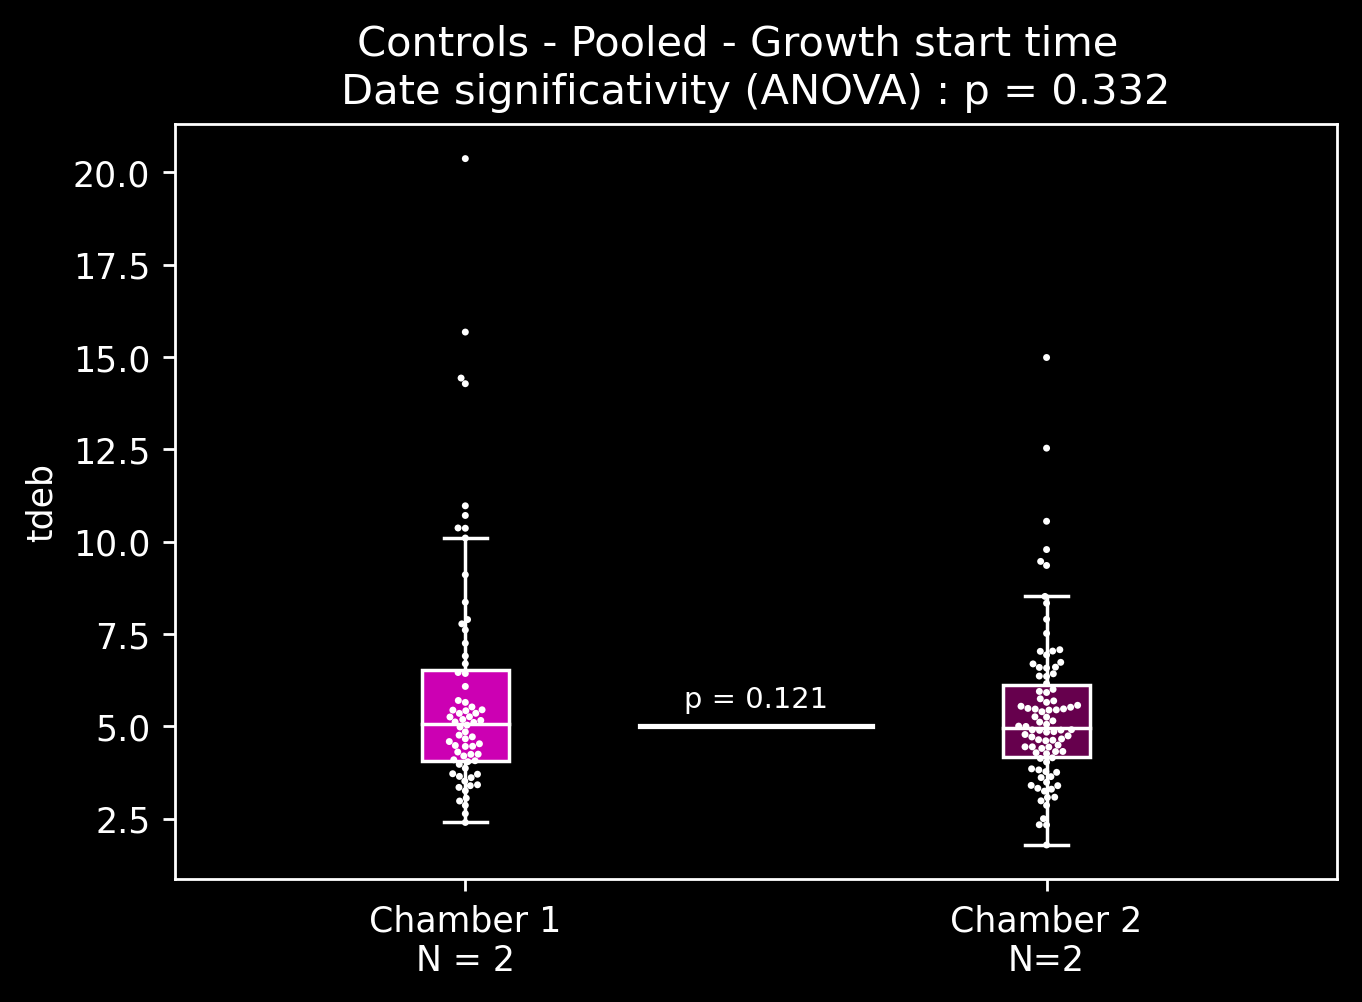

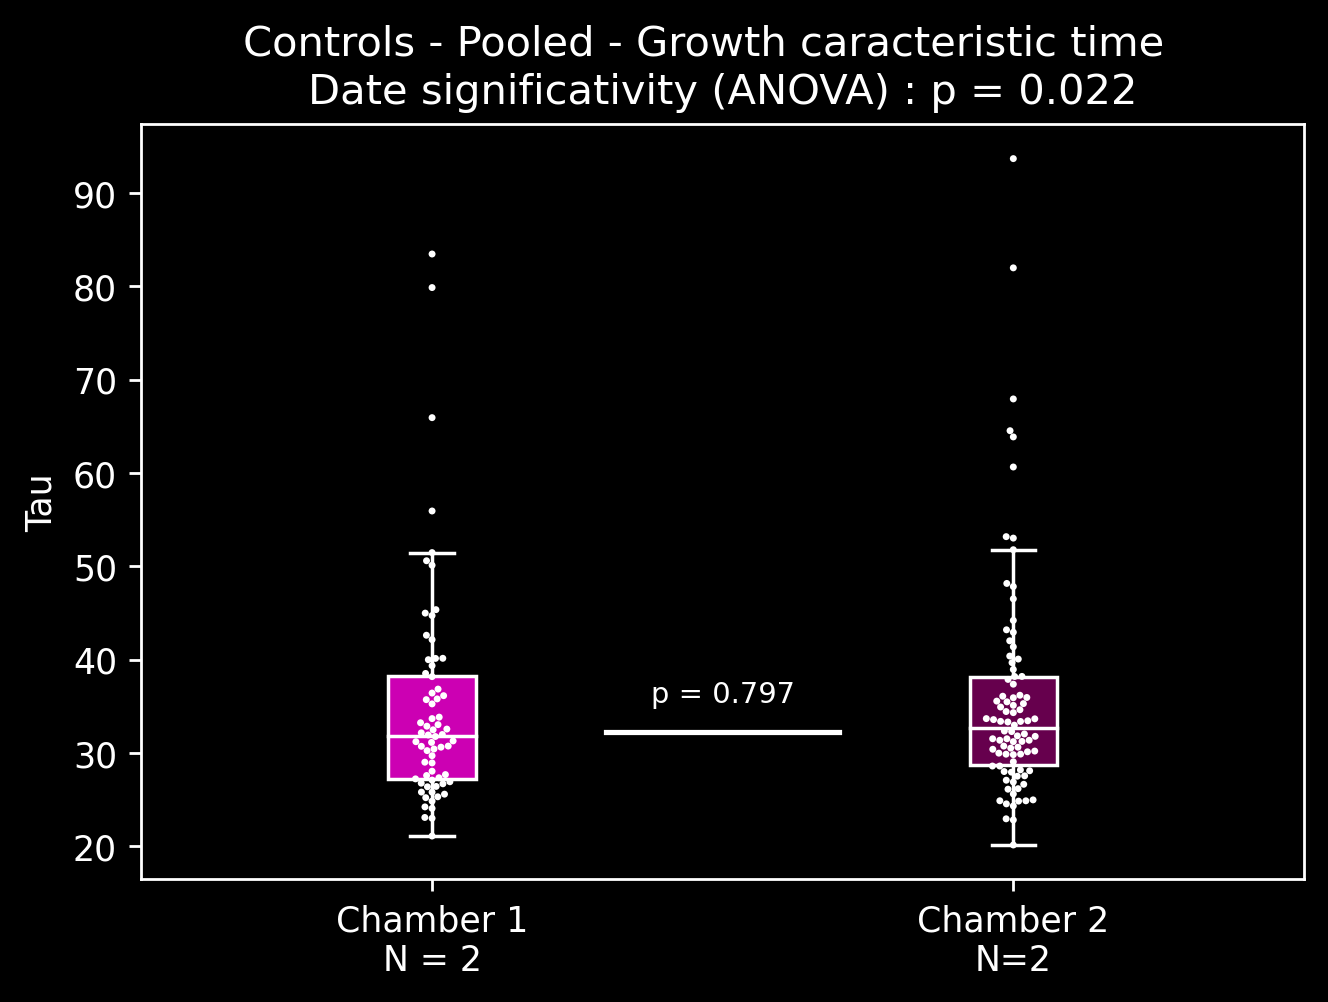

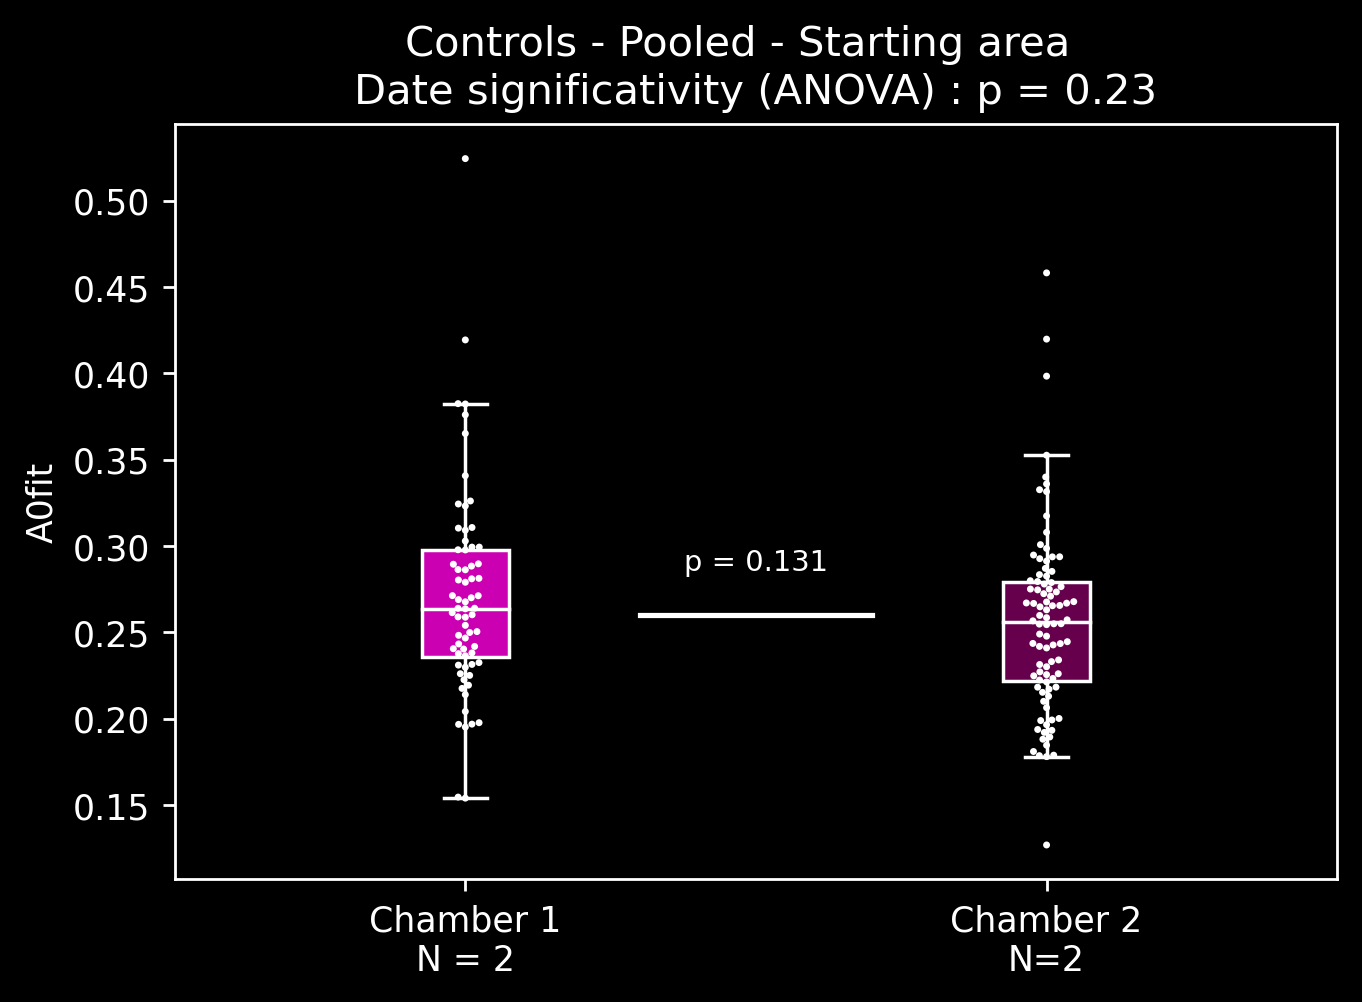

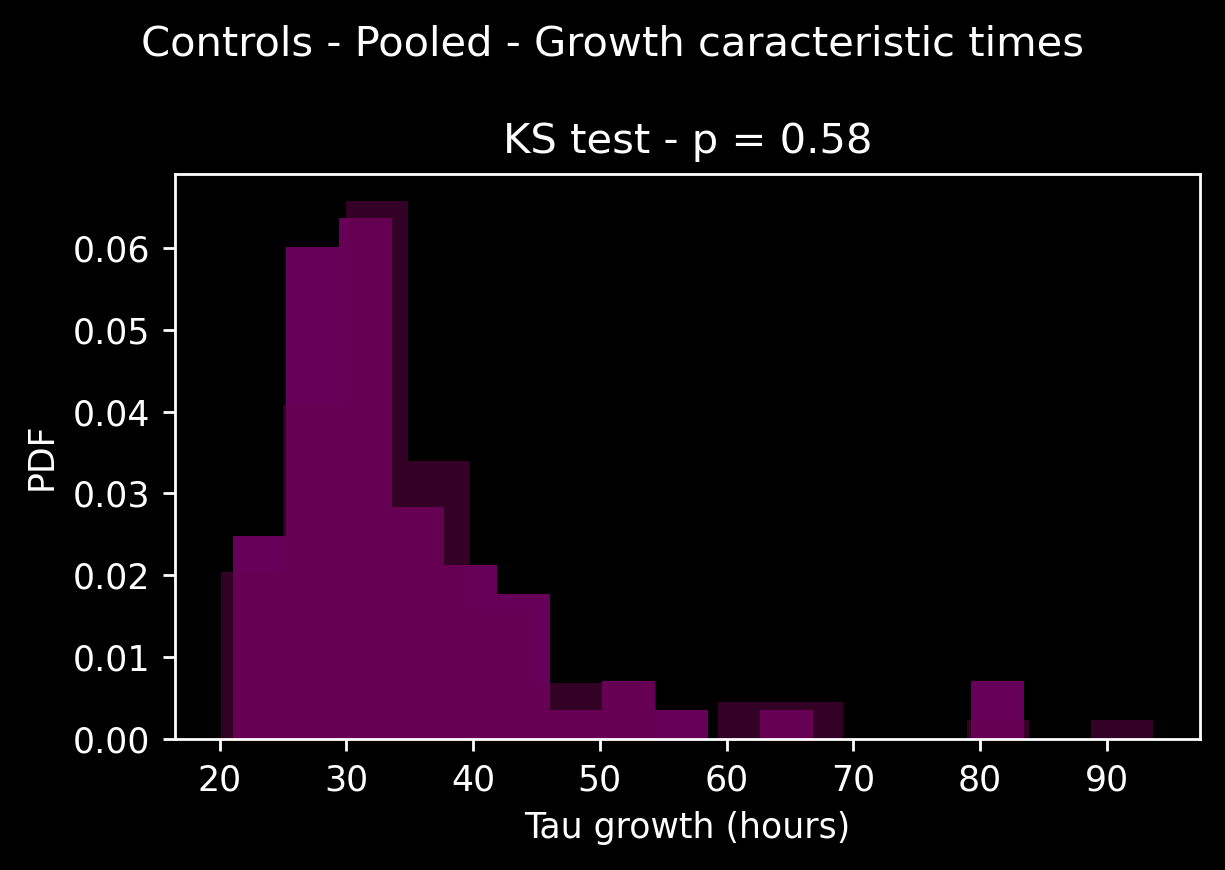

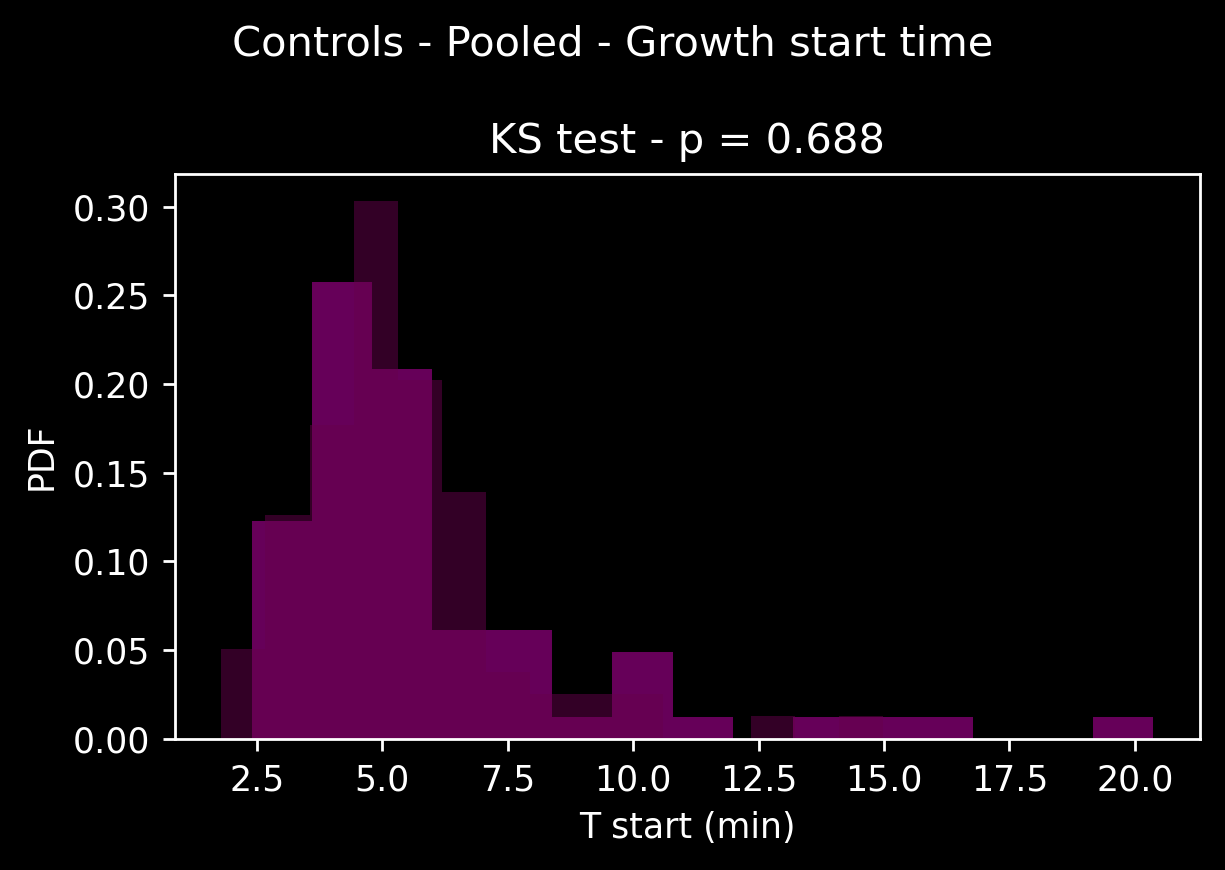

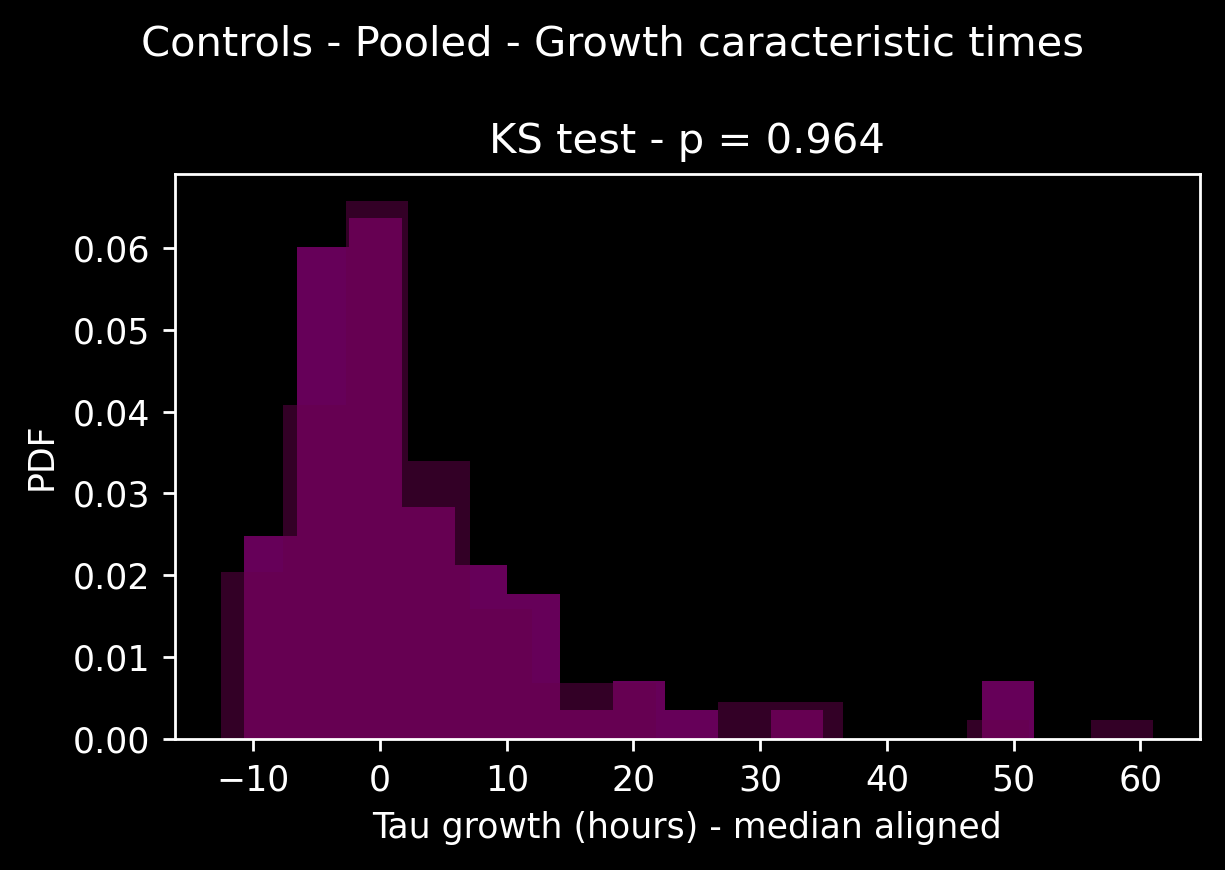

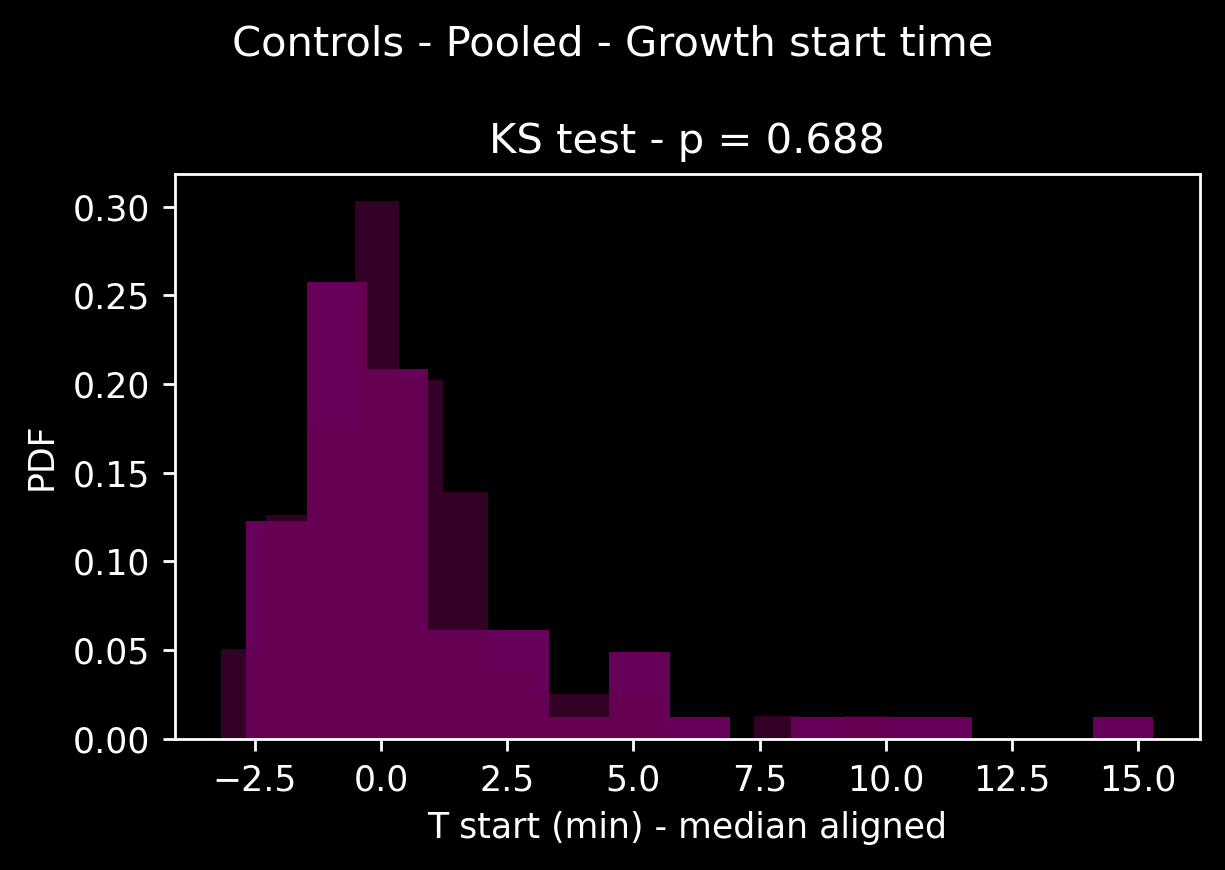

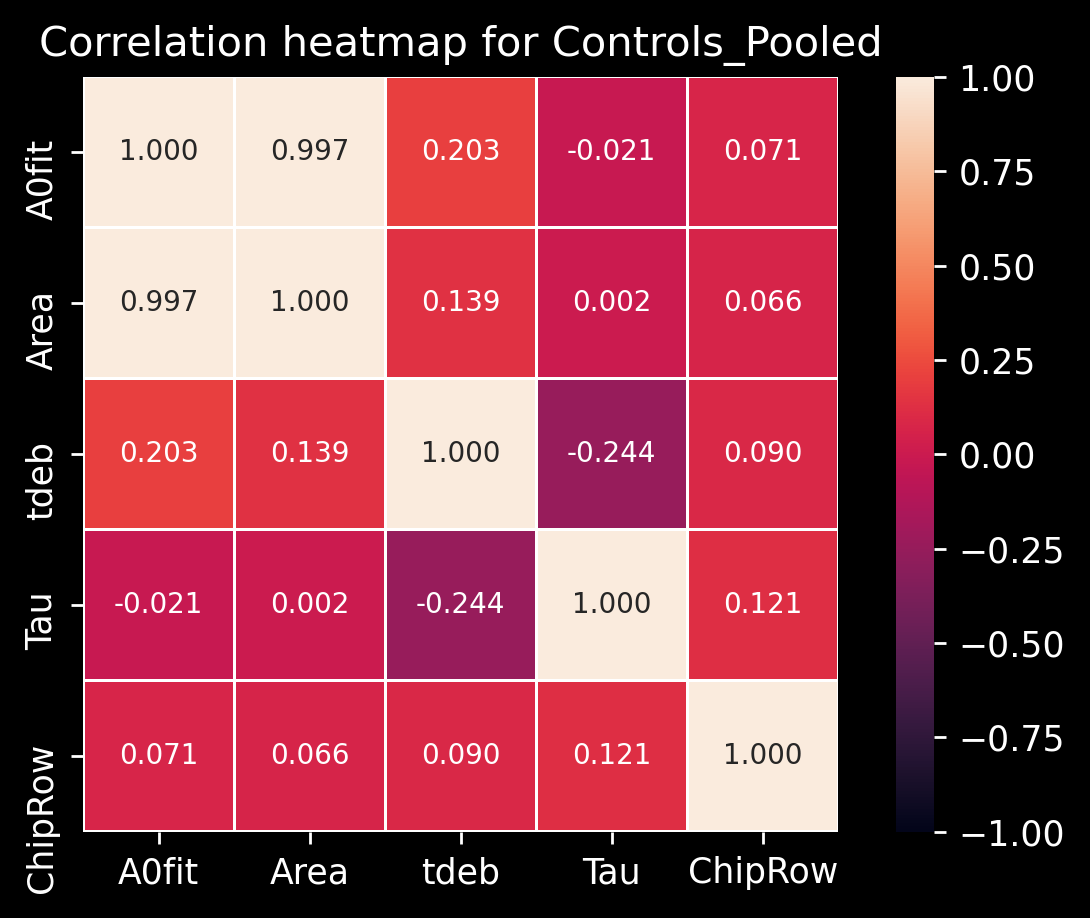

In [16]:


# Plot 
figTdeb,axTdeb,medTdeb,figTau,axTau,medTau,figA0,axA0,medA0 = compareGrowth([GlobalData_Ct1, GlobalData_Ct2],
             ['Chamber 1\nN = 2','Chamber 2\nN=2'],[LightPurple, DarkPurple], 
             PFig, 'Controls - Pooled', showcurve = False, showbox = True,showhist = True, nbins = 15,stats=None);


### ANOVA 

## Tdeb
resTdeb = TwowayANOVA('tdeb',['0124','0124','0214','0214'],['Chamber1','Chamber2','Chamber1','Chamber2'],
                [GlobalData220124_Ct1,GlobalData220124_Ct2,GlobalData220214_Ct1,GlobalData220214_Ct2]);

pDateTdeb = resTdeb.loc['C(Date)','PR(>F)']
pCondTdeb = resTdeb.loc['C(Condition)','PR(>F)']

axTdeb.set_title('Date significativity (ANOVA) : p = ' + str(round(pDateTdeb*1000)/1000))
axTdeb.plot([0.3, 0.7],[np.mean(medTdeb), np.mean(medTdeb)],'-w')
axTdeb.text(0.5,np.mean(medTdeb)*1.1,'p = ' + str(round(pCondTdeb*1000)/1000), ha='center',fontsize='small')


## tau
resTau = TwowayANOVA('Tau',['0124','0124','0214','0214'],['Chamber1','Chamber2','Chamber1','Chamber2'],
                [GlobalData220124_Ct1,GlobalData220124_Ct2,GlobalData220214_Ct1,GlobalData220214_Ct2]);

pDateTau = resTau.loc['C(Date)','PR(>F)']
pCondTau = resTau.loc['C(Condition)','PR(>F)']

axTau.set_title('Date significativity (ANOVA) : p = ' + str(round(pDateTau*1000)/1000))
axTau.plot([0.3, 0.7],[np.mean(medTau), np.mean(medTau)],'-w')
axTau.text(0.5,np.mean(medTau)*1.1,'p = ' + str(round(pCondTau*1000)/1000), ha='center',fontsize='small')


## A0
resA0 = TwowayANOVA('A0fit',['0124','0124','0214','0214'],['Chamber1','Chamber2','Chamber1','Chamber2'],
                [GlobalData220124_Ct1,GlobalData220124_Ct2,GlobalData220214_Ct1,GlobalData220214_Ct2]);

pDateA0 = resA0.loc['C(Date)','PR(>F)']
pCondA0 = resA0.loc['C(Condition)','PR(>F)']

axA0.set_title('Date significativity (ANOVA) : p = ' + str(round(pDateA0*1000)/1000))
axA0.plot([0.3, 0.7],[np.mean(medA0), np.mean(medA0)],'-w')
axA0.text(0.5,np.mean(medA0)*1.1,'p = ' + str(round(pCondA0*1000)/1000), ha='center',fontsize='small')

### Correlation with starting size
Corr([GlobalData_Ct1.append(GlobalData_Ct2)],['Controls_Pooled'],colors = [Purple],
         columns = ['A0fit','Area','tdeb','Tau','ChipRow'],
         columnslabels = ['A0fit (mm²)', 'A0exp (mm²)', 'Tstart (min)', 'Tau (min)','Chip position'])



#### Osmotic choc correlation on Ctrls from 14-02-2022

n = 23
n = 24


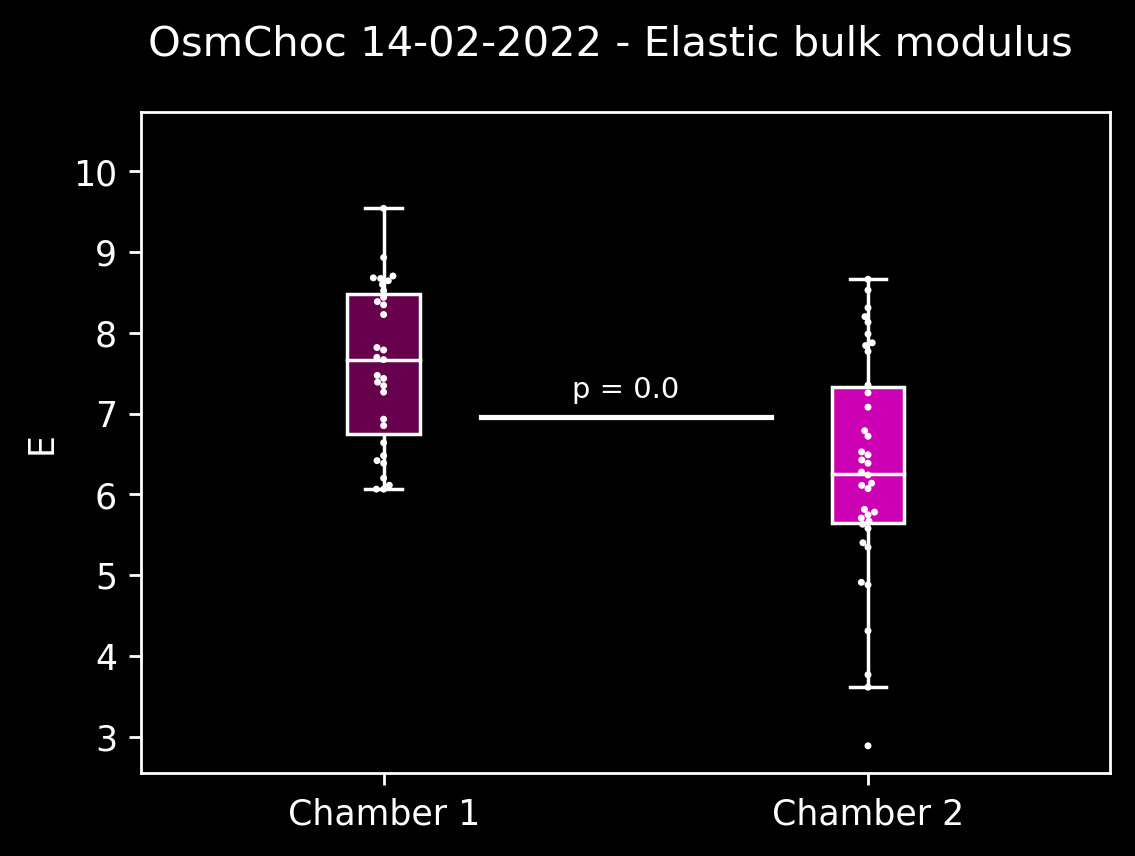

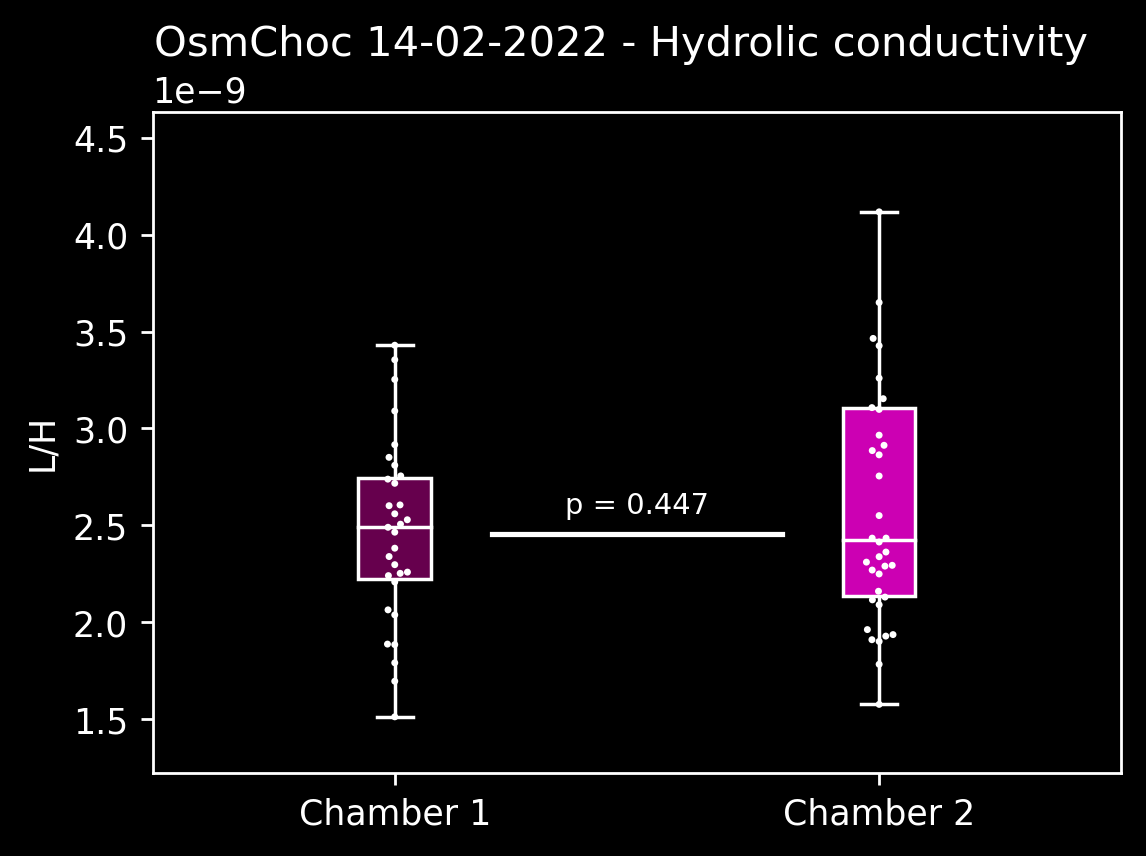

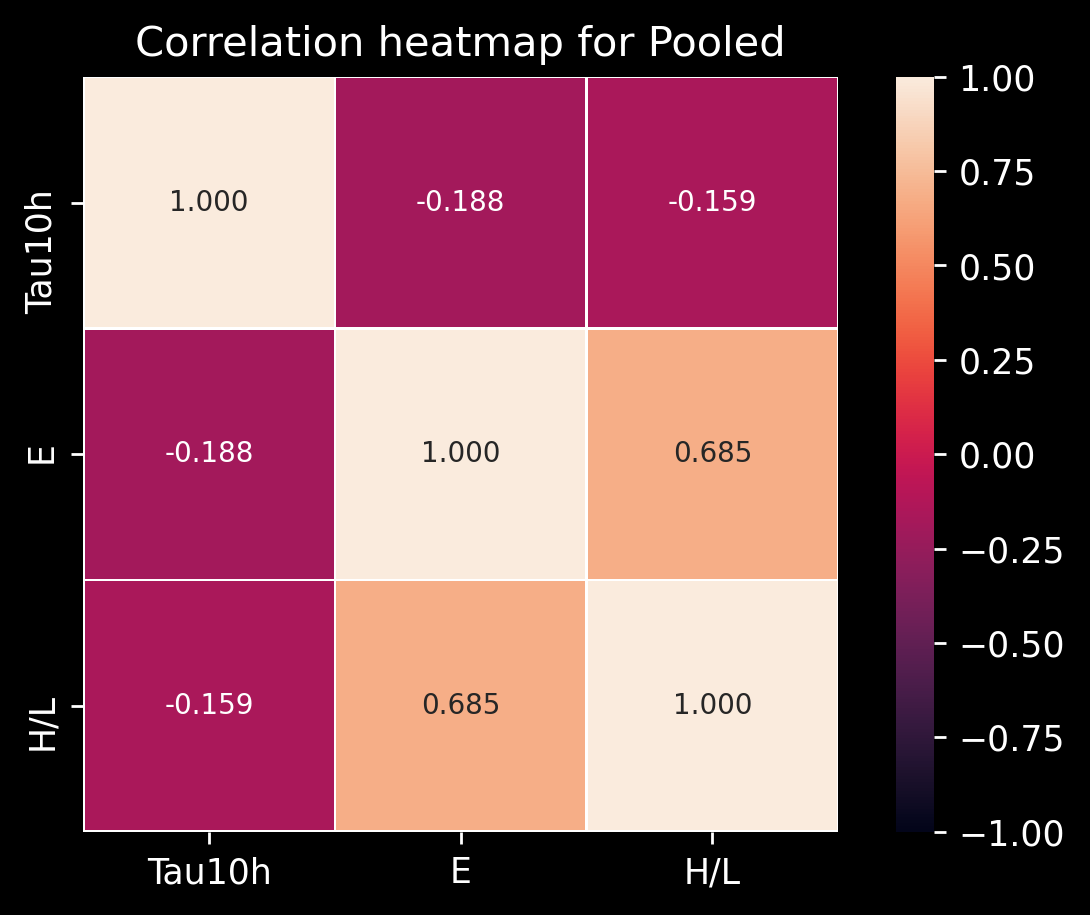

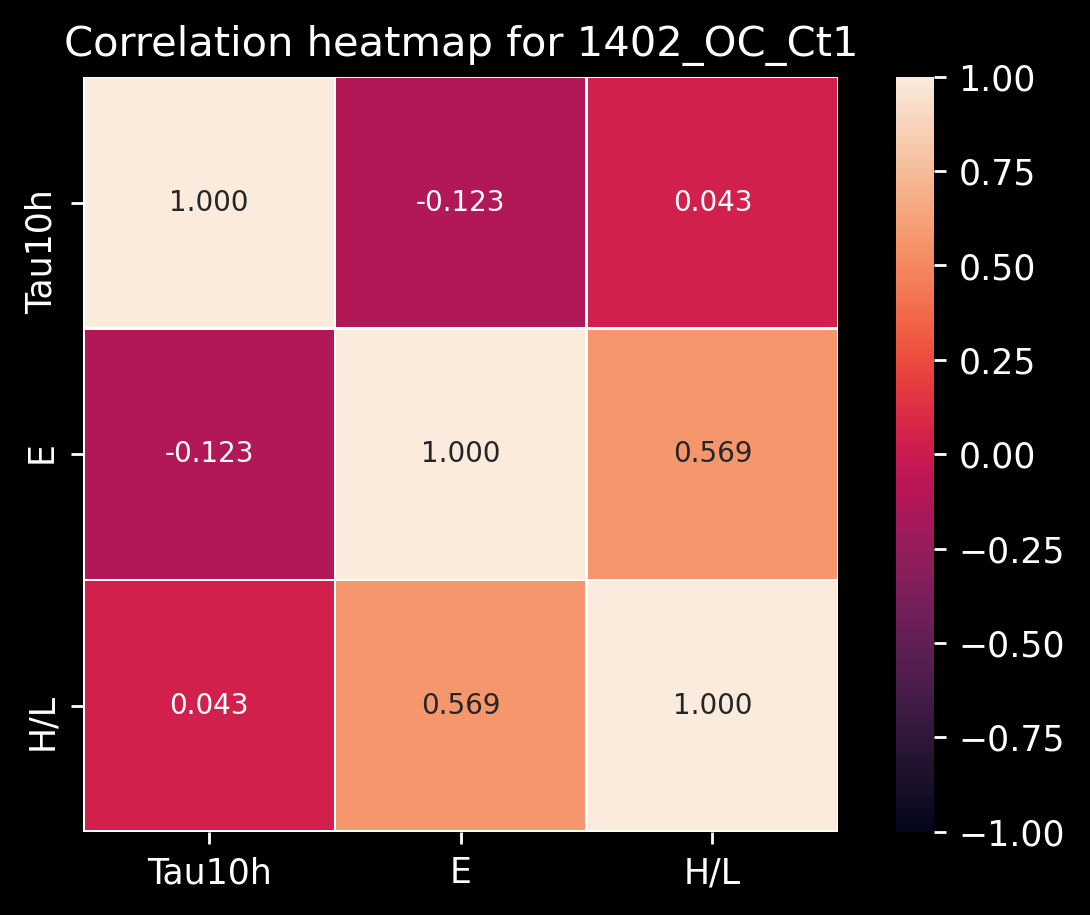

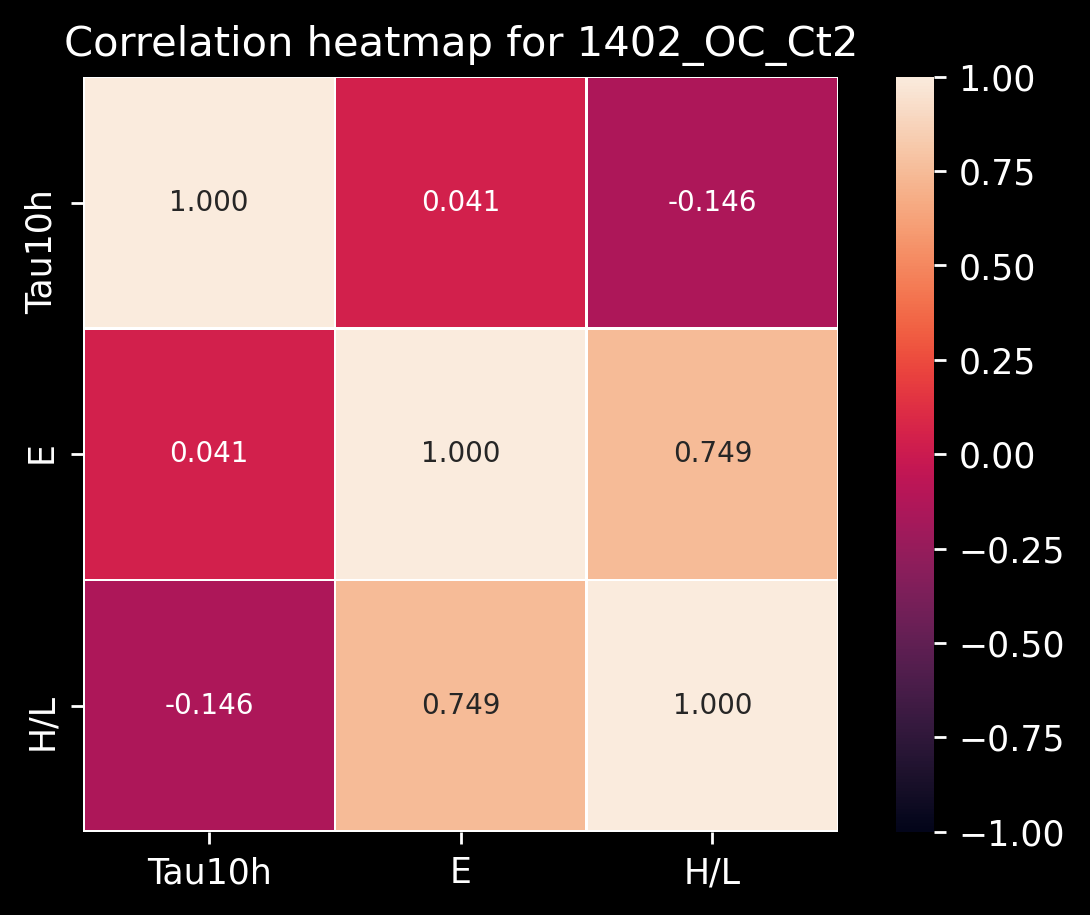

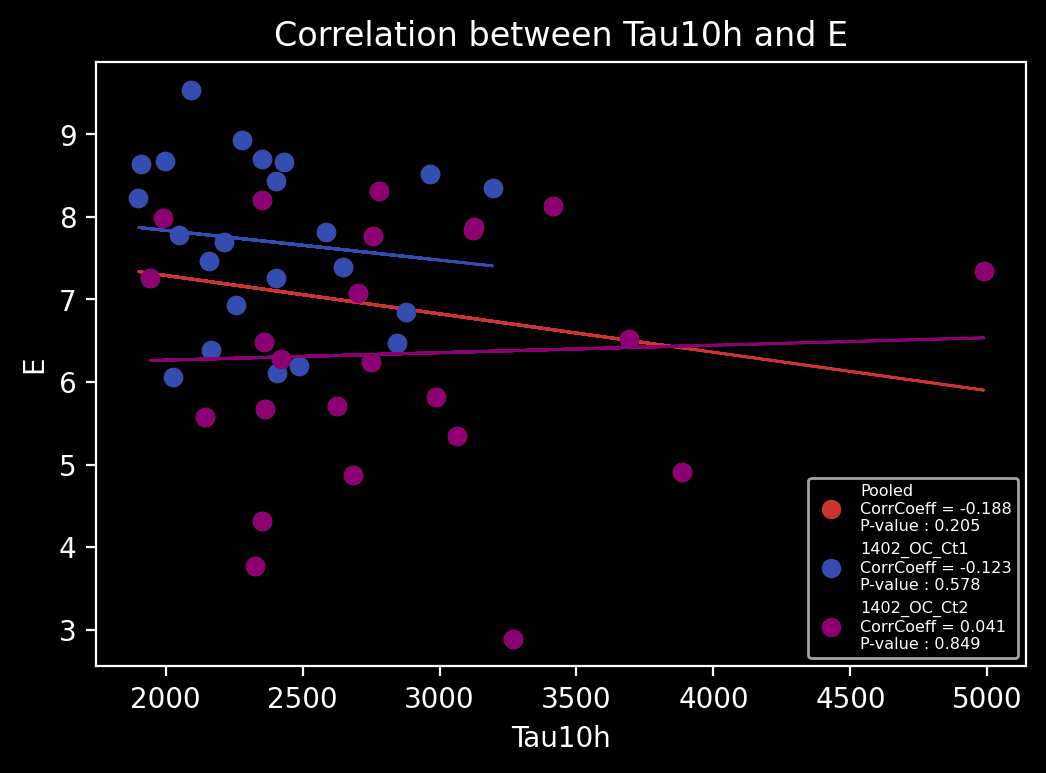

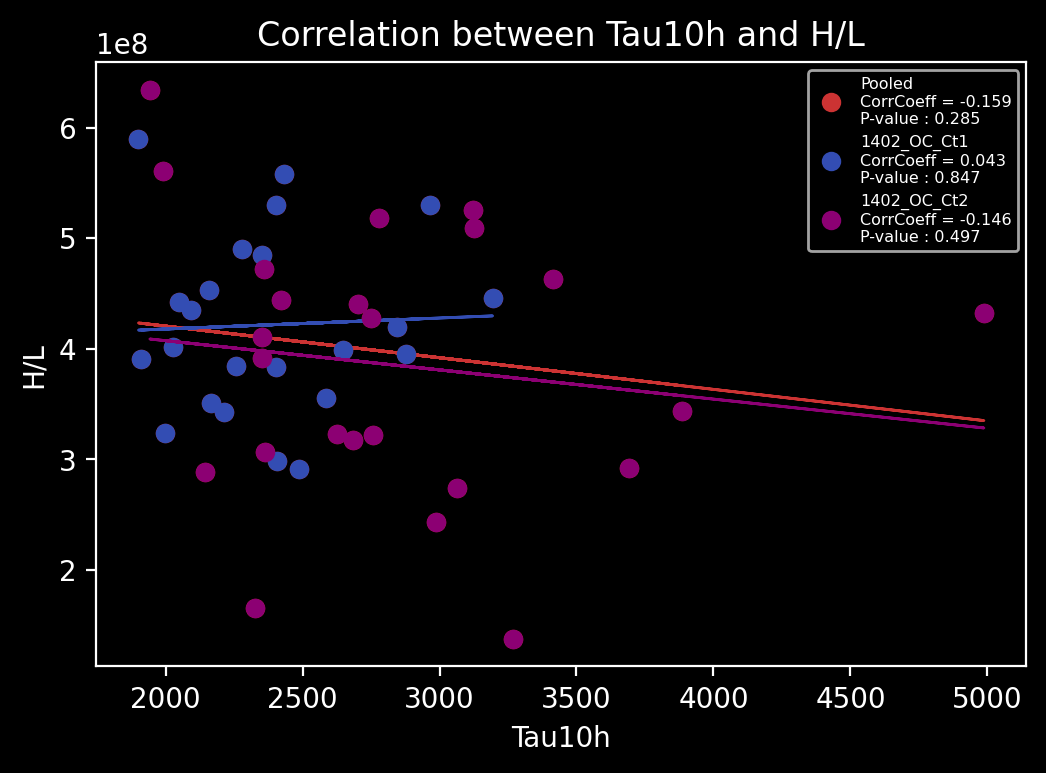

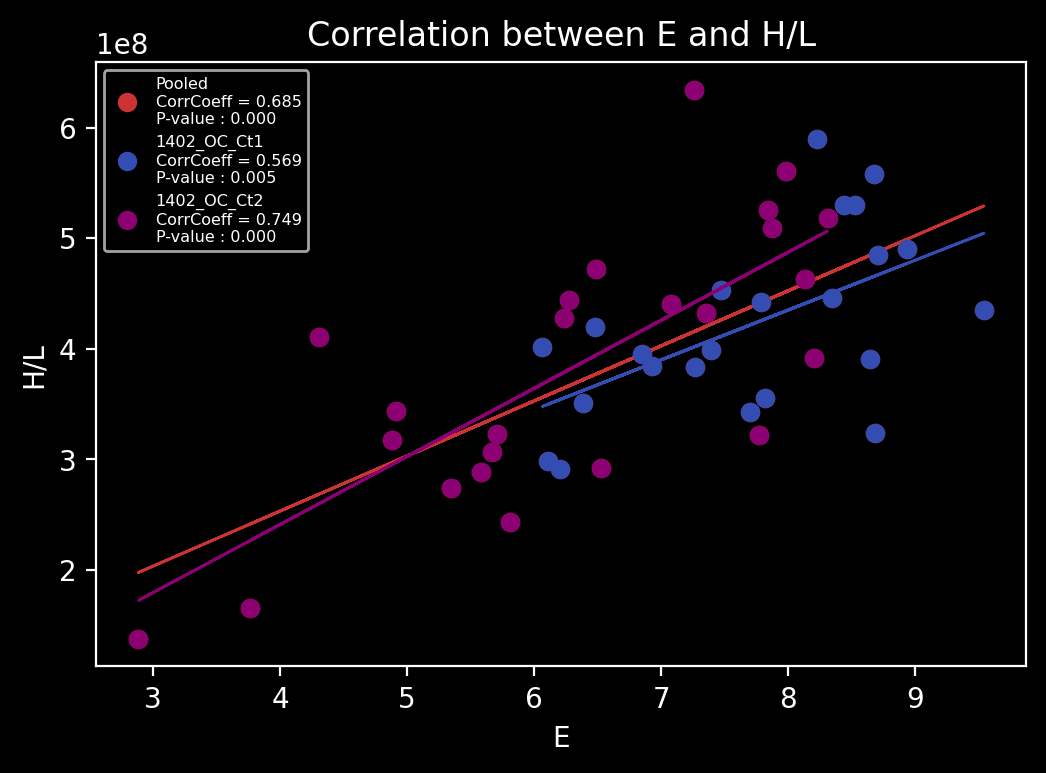

In [17]:
compareHydroMech([GlobalData220214_Ct1_Osmo, GlobalData220214_Ct2_Osmo],
             ['Chamber 1','Chamber 2'],[DarkPurple,LightPurple], 
             PFig, 'OsmChoc 14-02-2022', showbox = True,showhist = False, nbins = 'auto',stats='ranksum');


# GOC_Comp([GlobalData220214_Ct1],[GlobalData220214_Ct1_Osmo],['Tau','Tau10h'],
#          ['K','L'],['Tau','Tau10h'],
#          ['Module K (MPa)','Hydraulic permitivity (m.s-1.Pa-1)','Tau growth (min)', 'Tau growth 10 last hours (min)'],
#          '1402_Ct1_OC',[DarkPurple],PlotFits=True)

# GOC_Comp([GlobalData220214_Ct2],[GlobalData220214_Ct2_Osmo],['Tau','Tau10h'],
#          ['K','L'],['Tau','Tau10h'],
#          ['Module K (MPa)','Hydraulic permitivity (m.s-1.Pa-1)','Tau growth (min)', 'Tau growth 10 last hours (min)'],
#          '1402_Ct2_OC',[LightPurple],PlotFits=True)

GOC_Comp([GlobalData220214_Ct1,GlobalData220214_Ct2],[GlobalData220214_Ct1_Osmo,GlobalData220214_Ct2_Osmo],['Tau10h'],
         ['E','H/L'],['Tau10h'],['E','H/L'],['1402_OC_Ct1','1402_OC_Ct2'],[Red,Blue,Purple],PlotFits=True)





#### Growth 100mM +OC (01-03-22)

##### Growth quantif

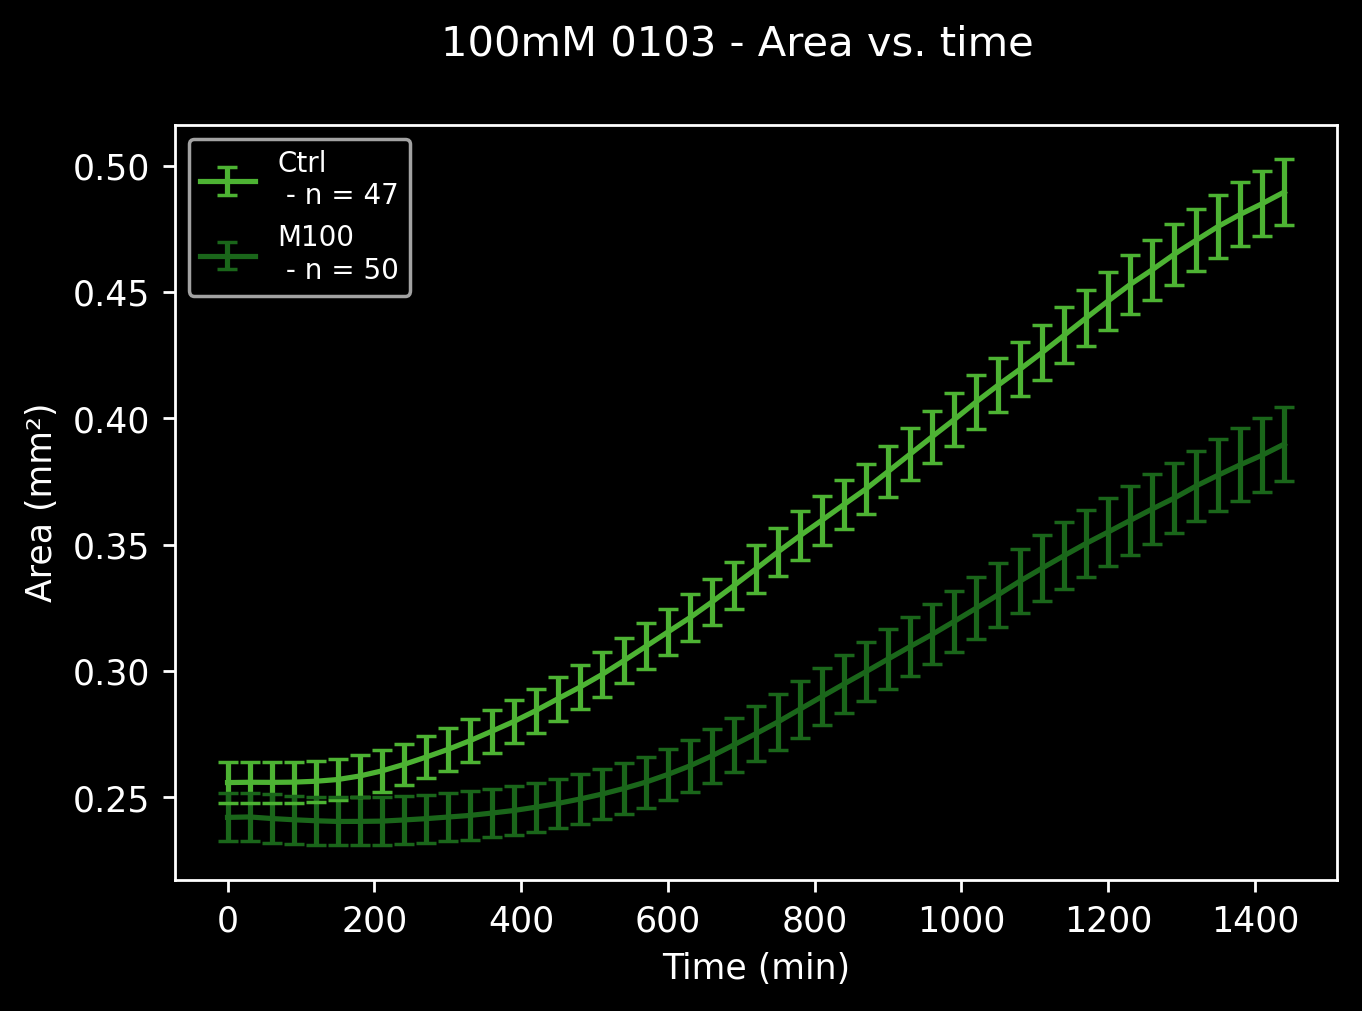

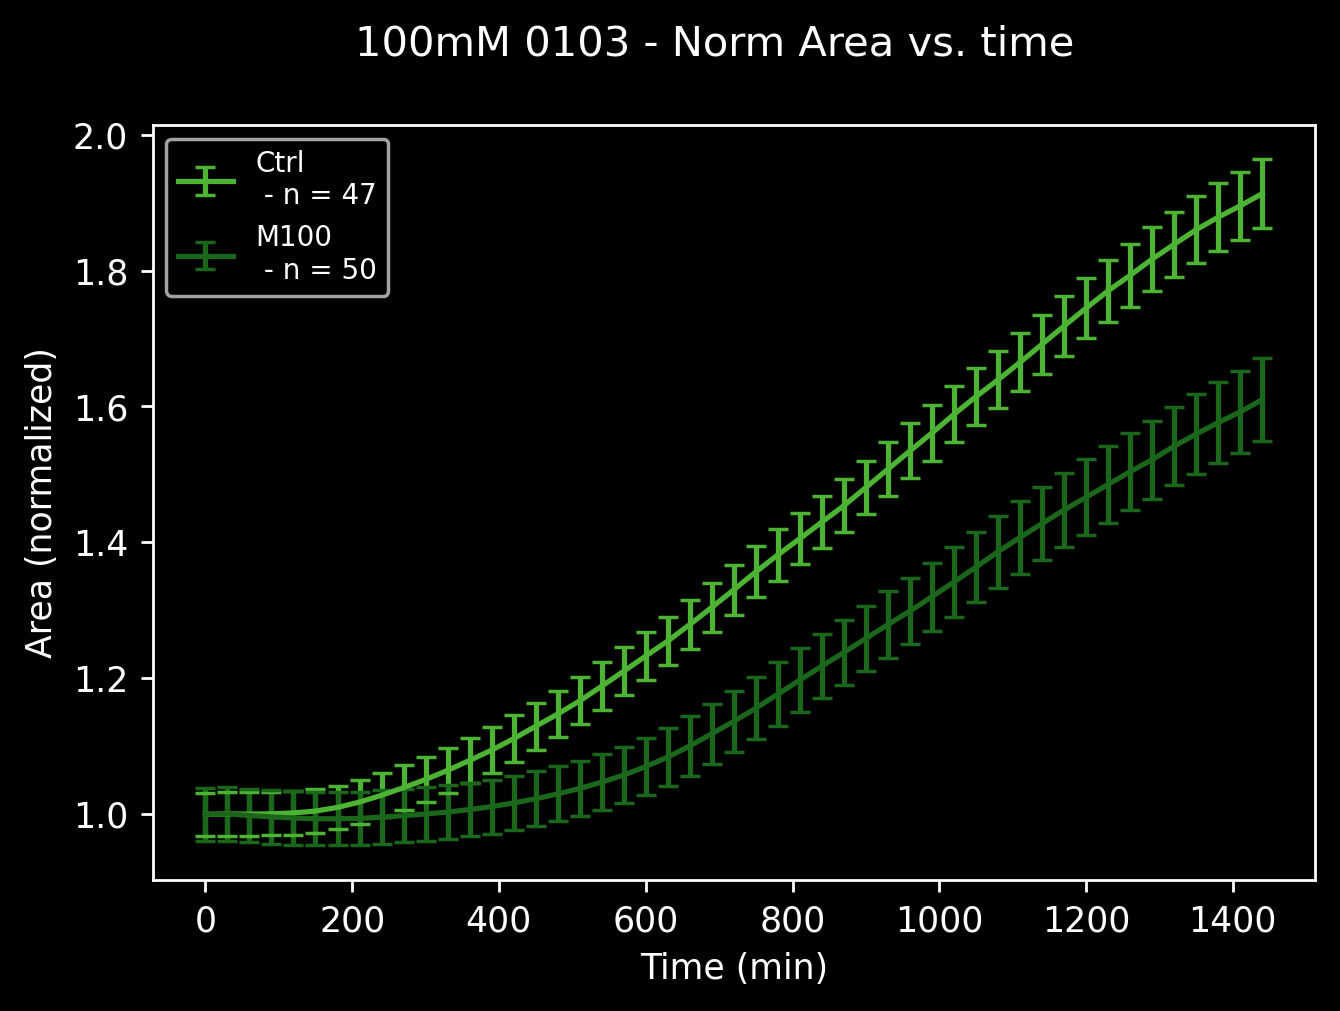

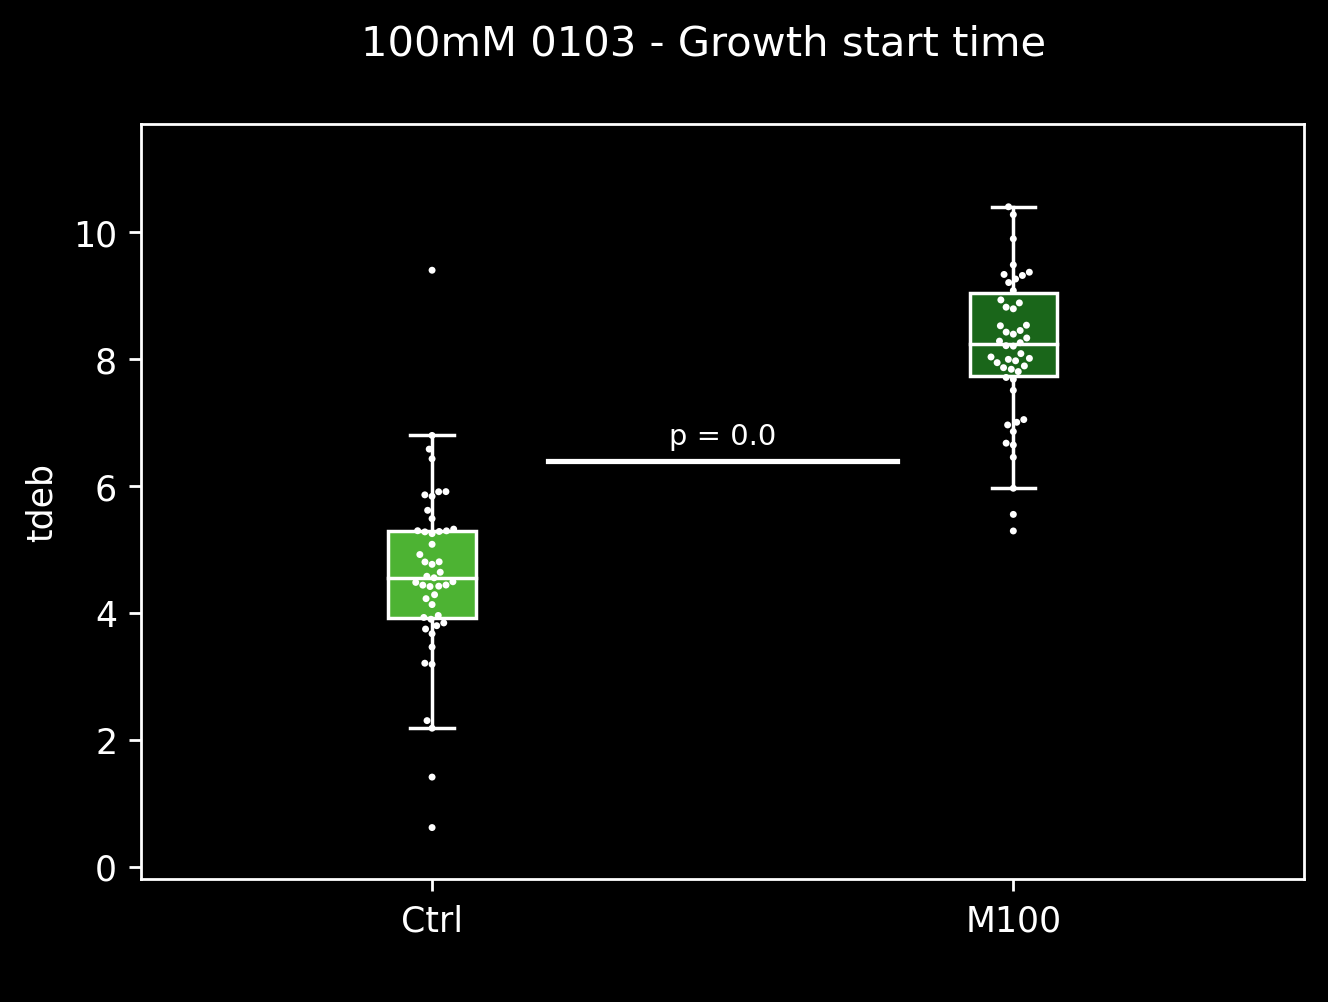

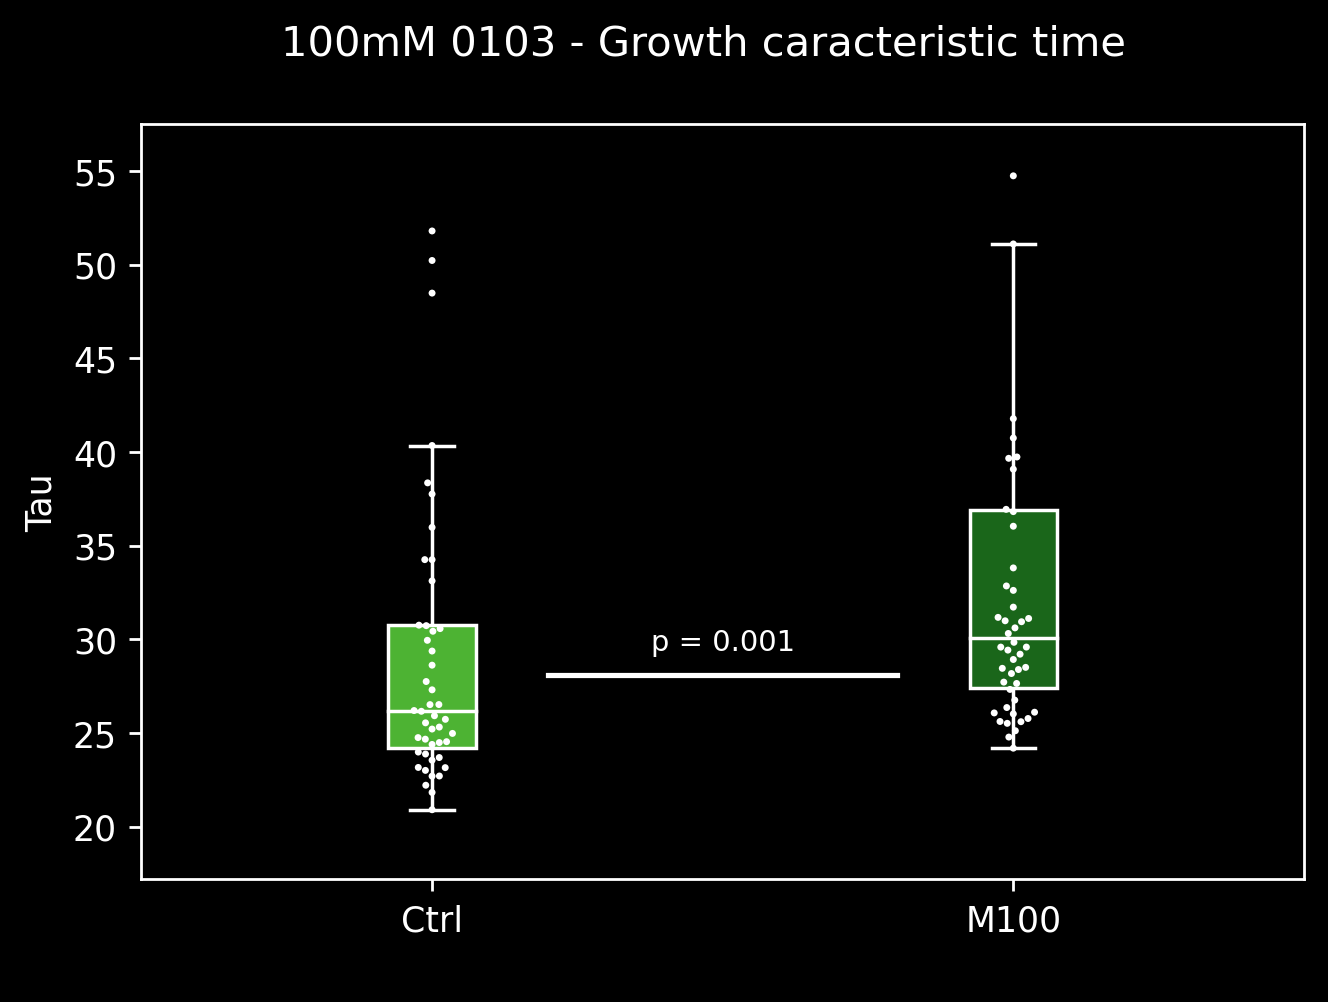

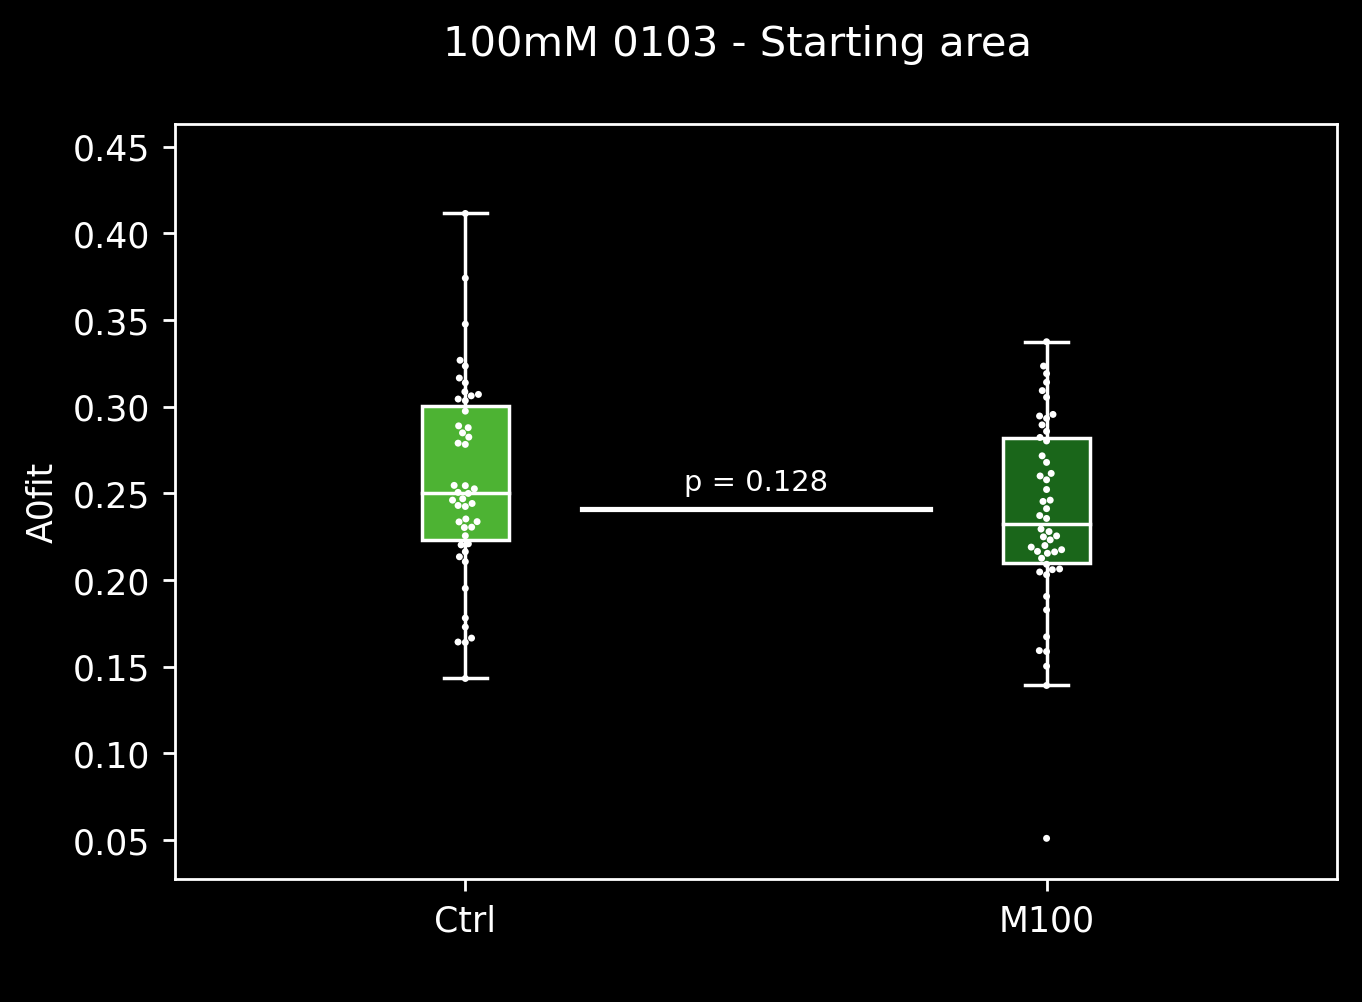

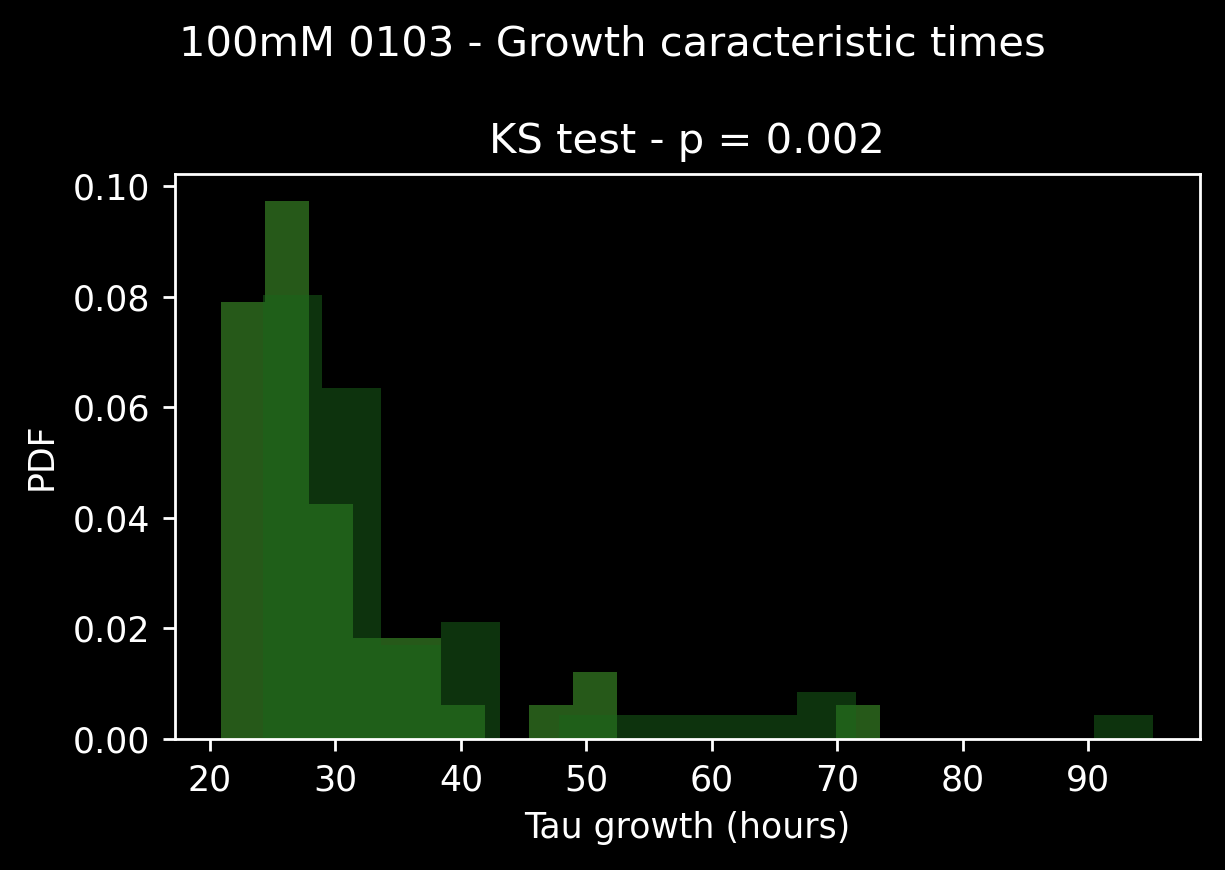

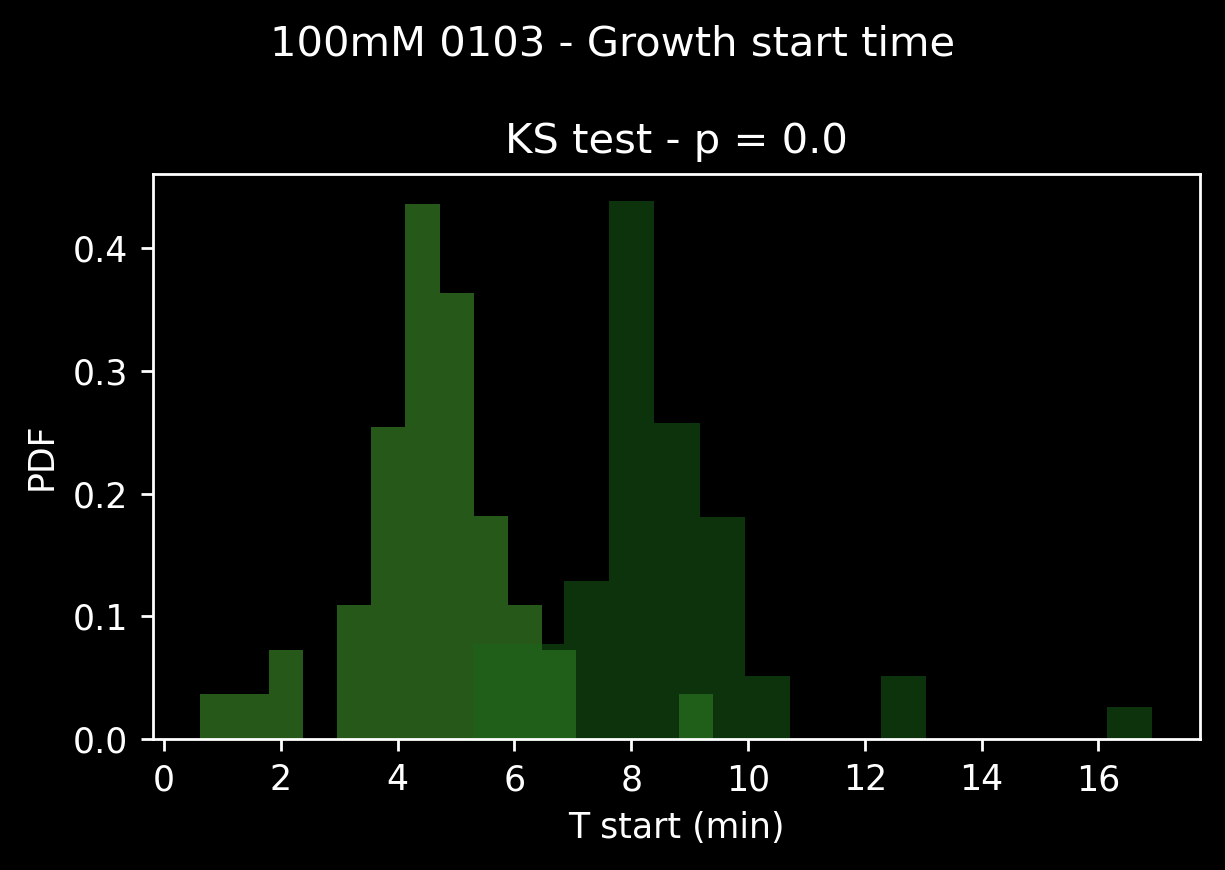

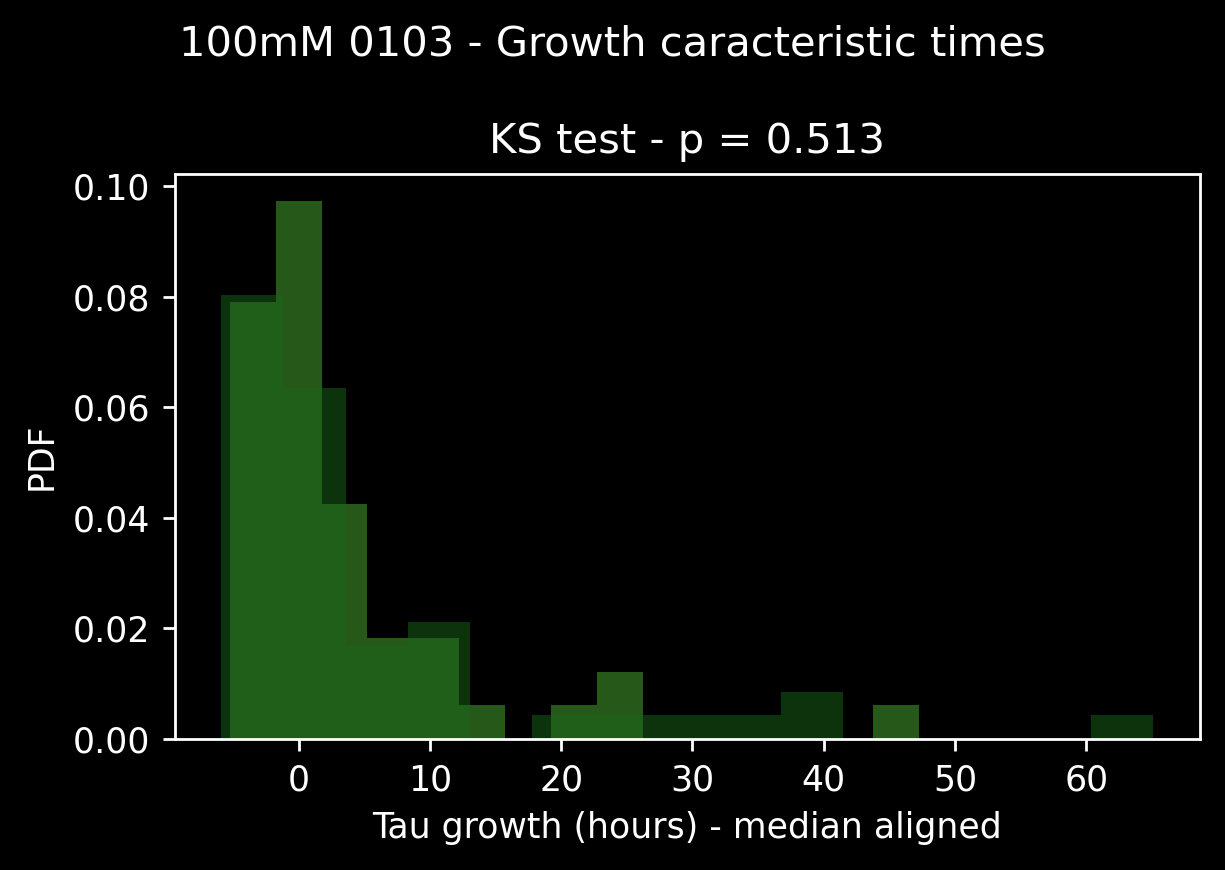

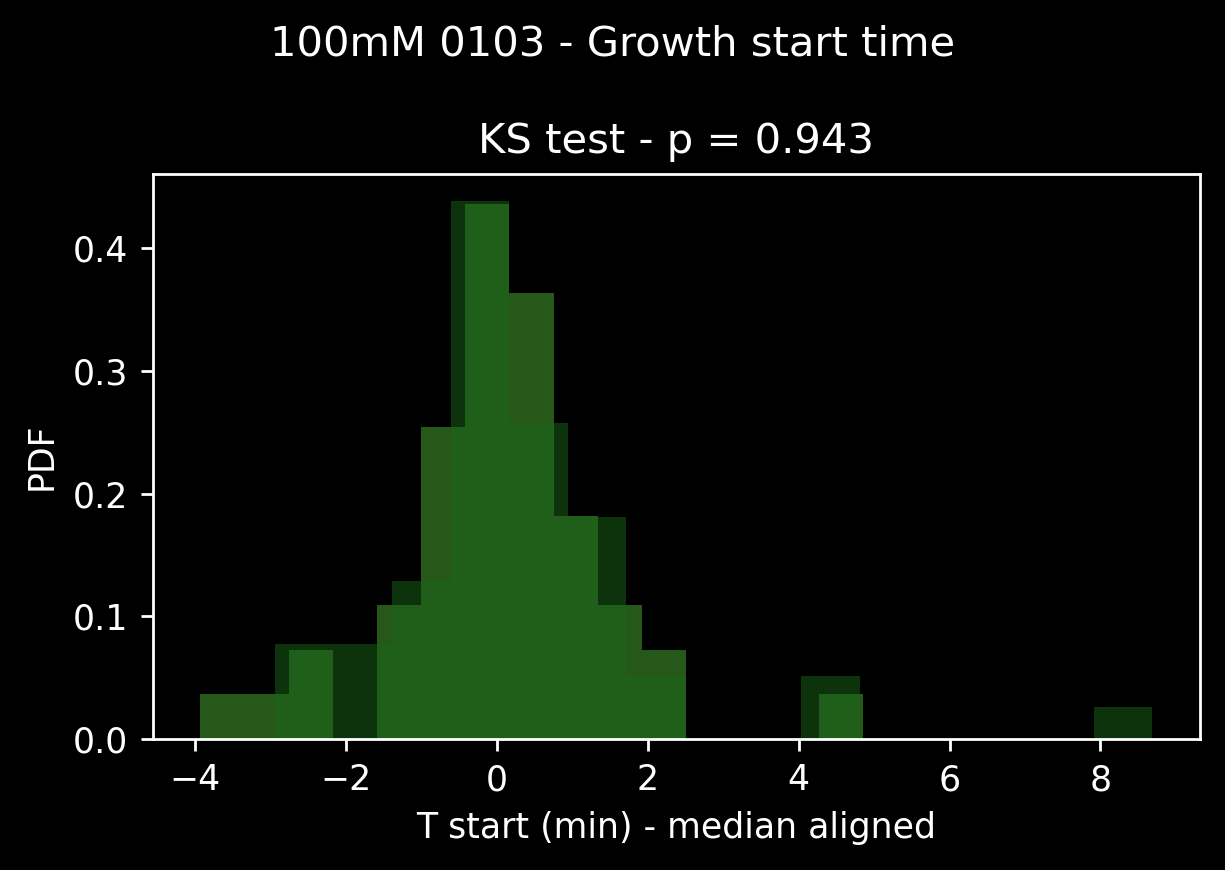

In [18]:
# Plot 

compareGrowth([GlobalData220301_Ct, GlobalData220301_M100],
             ['Ctrl\n','M100\n'],[Green, DarkGreen], 
             PFig, '100mM 0103', showcurve = True, showbox = True,showhist = True, nbins = 15,stats='ranksum');

##### OC correlation

In [ ]:
compareHydroMech([GlobalData220301_Ct_Osmo,GlobalData220301_M100_Osmo],
             ['Ctrl','Manitol 100mM'],[Green, DarkGreen], 
             PFig, 'OsmChoc 01-03-2022', showbox = True,showhist = True, nbins = 15,stats='ranksum');

# GOC_Comp(GlobalData220301_Ct,GlobalData220301_Ct_Osmo,['Tau','Tau10h'],
#          ['K','L'],['Tau','Tau10h'],
#          ['Module K (MPa)','Hydraulic permitivity (m.s-1.Pa-1)','Tau growth (min)', 'Tau growth 10 last hours (min)'],
#          '0103_Ctrl_OC',[PastelGreen],PlotFits=True)

# GOC_Comp(GlobalData220301_M100,GlobalData220301_M100_Osmo,['Tau','Tau10h'],
#          ['K','L'],['Tau','Tau10h'],
#          ['Module K (MPa)','Hydraulic permitivity (m.s-1.Pa-1)','Tau growth (min)', 'Tau growth 10 last hours (min)'],
#          '0103_100mM_OC',[DarkPastelGreen],PlotFits=True)

GOC_Comp([GlobalData220301_Ct,GlobalData220301_M100],[GlobalData220301_Ct_Osmo,GlobalData220301_M100_Osmo],['Tau10h'],
         ['E','H/L'],['Tau10'],['E','H/L'],['0103_Ct_OC','0103_100mM_OC'],[Green,Blue,Yellow],PlotFits=True)

### Bad data plots

In [ ]:
##### Growth quantif
# GlobalData_Ct = GlobalData_Ct1.append(GlobalData_Ct2)

# compareGrowth([GlobalData_Ct1,GlobalData220203_Ct1],
#              ['GoodCtrls','Bad data 030222'],[DarkGreen, Blue], 
#              PFig, 'DV6 ctrls vs 030222', showcurve = False, showbox = True,showhist = True, nbins = 15,stats='ranksum');

# compareGrowth([GlobalData_Ct1,GlobalData220405_Ct1],
#              ['GoodCtrls','Bad data 050422'],[DarkGreen, Blue], 
#              PFig, 'DV6 ctrls vs 050422', showcurve = False, showbox = True,showhist = True, nbins = 15,stats='ranksum');



## Test zone
